# Project 4 : West Nile Virus Prediction

## Problem Statement

## Executive Summary

## Sections

- [Import libraries](#Import-libraries)

## Import libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier, BaggingClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,roc_auc_score

import pyreadr
import myfunctions as f
import io
import re

import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

%matplotlib inline

## Load Data

In [3]:
df_train = pd.read_csv('../datasets/train.csv')
df_test = pd.read_csv('../datasets/test.csv')
df_spray = pd.read_csv('../datasets/spray.csv')
df_weather = pd.read_csv('../datasets/weather.csv')

## Data Cleaning

### General Cleaning for all dataframes

In [4]:
df_train.head()

Date                                            Address  \
0  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2  2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

In [5]:
df_test.head()

Id        Date                                            Address  \
0   1  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1   2  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2   3  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
3   4  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
4   5  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2           CULEX PIPIENS     41   N OAK PARK AVE  T002   
3        CULEX SALINARIUS     41   N OAK PARK AVE  T002   
4         CULEX TERRITANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
2  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
3  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
4  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9

**Comment**

df_test differs from df_train in that it does not have the `WnvPresent` column, which is expected since it is the predicted variable, but also the `NumMosquitos` column. It also has an extra `Id` column

In [6]:
df_weather.head()

Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
1        2  2007-05-01    84    52   68      M        51      57    0    3   
2        1  2007-05-02    59    42   51     -3        42      47   14    0   
3        2  2007-05-02    60    43   52      M        42      47   13    0   
4        1  2007-05-03    66    46   56      2        40      48    9    0   

   ... CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
0  ...             0      M      0.0        0.00       29.10    29.82   
1  ...             M      M        M        0.00       29.18    29.82   
2  ...      BR     0      M      0.0        0.00       29.38    30.09   
3  ...   BR HZ     M      M        M        0.00       29.44    30.08   
4  ...             0      M      0.0        0.00       29.39    30.12   

  ResultSpeed ResultDir  AvgSpeed  
0         1.7        27       9.2  
1         2.7        25       9.6  
2        13.0         4      13.4  
3        13.3         2      13.4  
4        11.7         7      11.9  

[5 rows x 22 columns]

In [7]:
df_spray.head()

Date        Time   Latitude  Longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163
1  2011-08-29  6:57:08 PM  42.391348 -88.089163
2  2011-08-29  6:57:18 PM  42.391022 -88.089157
3  2011-08-29  6:57:28 PM  42.390637 -88.089158
4  2011-08-29  6:57:38 PM  42.390410 -88.088858

In [8]:
# Apply lower() to column names for all 4 dataframes
df_weather.columns = df_weather.columns.str.lower()
df_train.columns = df_train.columns.str.lower()
df_spray.columns = df_spray.columns.str.lower()
df_test.columns = df_test.columns.str.lower()

In [9]:
# Check datatypes
print('Train dataset')
print(df_train.dtypes)
print()
print('Test dataset')
print(df_test.dtypes)
print()
print('Weather dataset')
print(df_weather.dtypes)
print()
print('Spray dataset')
print(df_spray.dtypes)

Train dataset
date                       object
address                    object
species                    object
block                       int64
street                     object
trap                       object
addressnumberandstreet     object
latitude                  float64
longitude                 float64
addressaccuracy             int64
nummosquitos                int64
wnvpresent                  int64
dtype: object

Test dataset
id                          int64
date                       object
address                    object
species                    object
block                       int64
street                     object
trap                       object
addressnumberandstreet     object
latitude                  float64
longitude                 float64
addressaccuracy             int64
dtype: object

Weather dataset
station          int64
date            object
tmax             int64
tmin             int64
tavg            object
depart          object
dewpoin

In [10]:
# Change Date datatype to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_spray['date'] = pd.to_datetime(df_spray['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

In [11]:
# Check datatypes
print('Train dataset')
print(df_train.dtypes)
print()
print('Test dataset')
print(df_test.dtypes)
print()
print('Weather dataset')
print(df_weather.dtypes)
print()
print('Spray dataset')
print(df_spray.dtypes)

Train dataset
date                      datetime64[ns]
address                           object
species                           object
block                              int64
street                            object
trap                              object
addressnumberandstreet            object
latitude                         float64
longitude                        float64
addressaccuracy                    int64
nummosquitos                       int64
wnvpresent                         int64
dtype: object

Test dataset
id                                 int64
date                      datetime64[ns]
address                           object
species                           object
block                              int64
street                            object
trap                              object
addressnumberandstreet            object
latitude                         float64
longitude                        float64
addressaccuracy                    int64
dtype: object



In [12]:
# Create `day`, `month` and `year` columns for all 4 dataframes
df_spray['day'] = df_spray['date'].map(lambda x: x.day)
df_spray['month'] = df_spray['date'].map(lambda x: x.month)
df_spray['year'] = df_spray['date'].map(lambda x: x.year)

df_weather['day'] = df_weather['date'].map(lambda x: x.day)
df_weather['month'] = df_weather['date'].map(lambda x: x.month)
df_weather['year'] = df_weather['date'].map(lambda x: x.year)

df_train['day'] = df_train['date'].map(lambda x: x.day)
df_train['month'] = df_train['date'].map(lambda x: x.month)
df_train['year'] = df_train['date'].map(lambda x: x.year)

df_test['day'] = df_test['date'].map(lambda x: x.day)
df_test['month'] = df_test['date'].map(lambda x: x.month)
df_test['year'] = df_test['date'].map(lambda x: x.year)

In [13]:
# View data shapes
print(f'Train dataset: {df_train.shape}')
print(f'Weather dataset: {df_weather.shape}')
print(f'Spray dataset: {df_spray.shape}')
print(f'Test dataset: {df_test.shape}')

Train dataset: (10506, 15)
Weather dataset: (2944, 25)
Spray dataset: (14835, 7)
Test dataset: (116293, 14)


In [14]:
# Check for NA values
print(f'Train dataset: {df_train.isnull().sum().sum()}')
print(f'Weather dataset: {df_weather.isnull().sum().sum()}')
print(f'Spray dataset: {df_spray.isnull().sum().sum()}')
print(f'Test dataset: {df_test.isnull().sum().sum()}')

Train dataset: 0
Weather dataset: 0
Spray dataset: 584
Test dataset: 0


### Data cleaning for df_spray

In [15]:
# Closer look at Spray dataset
print(df_spray.isnull().sum())

date           0
time         584
latitude       0
longitude      0
day            0
month          0
year           0
dtype: int64


**Comment**

Column 'Time' has 584 empty cells but it is not important for our analysis.
The null values does not appear at random. Therefore, we will drop the column

In [16]:
df_spray.drop(columns='time',inplace=True)

In [17]:
df_spray.head()

date   latitude  longitude  day  month  year
0 2011-08-29  42.391623 -88.089163   29      8  2011
1 2011-08-29  42.391348 -88.089163   29      8  2011
2 2011-08-29  42.391022 -88.089157   29      8  2011
3 2011-08-29  42.390637 -88.089158   29      8  2011
4 2011-08-29  42.390410 -88.088858   29      8  2011

### Data cleaning for df_weather

In [18]:
# Define function to replace entires with M, blank spaces and '-' with Nan values, while T was replace with 0.05
# https://wgntv.com/weather/what-are-traces-of-precipitation/
def update_cols(df):
    df.replace(['M','-',' ', '  T'],
               [np.nan, np.nan, np.nan, 0.05],
               inplace = True)
    
update_cols(df_weather)

In [19]:
df_weather.head()

station       date  tmax  tmin tavg depart  dewpoint wetbulb heat cool  \
0        1 2007-05-01    83    50   67     14        51      56    0    2   
1        2 2007-05-01    84    52   68    NaN        51      57    0    3   
2        1 2007-05-02    59    42   51     -3        42      47   14    0   
3        2 2007-05-02    60    43   52    NaN        42      47   13    0   
4        1 2007-05-03    66    46   56      2        40      48    9    0   

   ... snowfall preciptotal stnpressure sealevel  resultspeed resultdir  \
0  ...      0.0        0.00       29.10    29.82          1.7        27   
1  ...      NaN        0.00       29.18    29.82          2.7        25   
2  ...      0.0        0.00       29.38    30.09         13.0         4   
3  ...      NaN        0.00       29.44    30.08         13.3         2   
4  ...      0.0        0.00       29.39    30.12         11.7         7   

  avgspeed day month  year  
0      9.2   1     5  2007  
1      9.6   1     5  2007  
2     13.4   2     5  2007  
3     13.4   2     5  2007  
4     11.9   3     5  2007  

[5 rows x 25 columns]

**Comment**

External research yields the following information for some of the parameters:

**Depart**

Departure from normal. The difference between column 4 and the 30 year normal temperature 
for this date. A minus (-) is number of degrees below normal.
A zero (0) indicates that the average for that day was the Normal.

**Wet bulb**

The Wet bulb temperature is the temperature the air needs to be cooled to (at constant pressure) 
in order to achieve a relative humidity (RH) of 100%.

**DewPoint**

At 100% relative humidity, the dew point temperature is equal to the air temperature 
(dry-bulb temperature) and it is lower at lower humidity.

In [20]:
# Check for null
df_weather.isnull().sum().sort_values(ascending=False)

water1         2944
codesum        1609
depart         1472
sunrise        1472
sunset         1472
depth          1472
snowfall       1472
tavg             11
cool             11
heat             11
sealevel          9
stnpressure       4
wetbulb           4
avgspeed          3
preciptotal       2
tmin              0
tmax              0
date              0
year              0
dewpoint          0
month             0
resultspeed       0
resultdir         0
day               0
station           0
dtype: int64

In [21]:
# Drop water1 column as it is missing all the data
df_weather.drop(['water1'], axis = 1, inplace= True)

# Replace Nan values in codesum column with 'MODERATE'
df_weather['codesum'] = df_weather['codesum'].replace(np.nan, 'MODERATE')

In [22]:
df_weather.dtypes

station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                   object
depart                 object
dewpoint                int64
wetbulb                object
heat                   object
cool                   object
sunrise                object
sunset                 object
codesum                object
depth                  object
snowfall               object
preciptotal            object
stnpressure            object
sealevel               object
resultspeed           float64
resultdir               int64
avgspeed               object
day                     int64
month                   int64
year                    int64
dtype: object

In [23]:
col_toflt = ['preciptotal', 'stnpressure', 'sealevel',
             'avgspeed', 'preciptotal', 'tavg',
             'depart', 'wetbulb', 'heat', 'cool',
             'sunrise', 'sunset']

for col in col_toflt:
    df_weather[col] = df_weather[col].astype(float)

In [24]:
df_weather.dtypes

station                 int64
date           datetime64[ns]
tmax                    int64
tmin                    int64
tavg                  float64
depart                float64
dewpoint                int64
wetbulb               float64
heat                  float64
cool                  float64
sunrise               float64
sunset                float64
codesum                object
depth                  object
snowfall               object
preciptotal           float64
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir               int64
avgspeed              float64
day                     int64
month                   int64
year                    int64
dtype: object

In [25]:
# Define function to convert temperature to Celsius
def fahrenheit_to_celsius(df,column_names):
    '''
    Convert temperature from Fahrenheit to Celsius
    
    Takes:
    df - DataFrame
    column_names - (list of str) - names of columns for conversion
    
    Returns:
    df
    '''
    for name in column_names:
        try:
            df[name] = round((df[name]-32)*5/9,2)
        except TypeError:
            continue
    return df

df_weather =  fahrenheit_to_celsius(df_weather,
                                    ['tmax','tmin','tavg','depart','dewpoint','wetbulb'])

In [26]:
# Verify that conversion is successful
df_weather.head()

station       date   tmax   tmin   tavg  depart  dewpoint  wetbulb  heat  \
0        1 2007-05-01  28.33  10.00  19.44  -10.00     10.56    13.33   0.0   
1        2 2007-05-01  28.89  11.11  20.00     NaN     10.56    13.89   0.0   
2        1 2007-05-02  15.00   5.56  10.56  -19.44      5.56     8.33  14.0   
3        2 2007-05-02  15.56   6.11  11.11     NaN      5.56     8.33  13.0   
4        1 2007-05-03  18.89   7.78  13.33  -16.67      4.44     8.89   9.0   

   cool  ...  snowfall  preciptotal stnpressure sealevel resultspeed  \
0   2.0  ...       0.0          0.0       29.10    29.82         1.7   
1   3.0  ...       NaN          0.0       29.18    29.82         2.7   
2   0.0  ...       0.0          0.0       29.38    30.09        13.0   
3   0.0  ...       NaN          0.0       29.44    30.08        13.3   
4   0.0  ...       0.0          0.0       29.39    30.12        11.7   

   resultdir  avgspeed  day  month  year  
0         27       9.2    1      5  2007  
1         25       9.6    1      5  2007  
2          4      13.4    2      5  2007  
3          2      13.4    2      5  2007  
4          7      11.9    3      5  2007  

[5 rows x 24 columns]

## Exploratory Data Analysis and Feature Engineering

### EDA - Weather dataset

In [27]:
# Masking weather data by station
df_weather_st1 = df_weather[df_weather['station']==1]
df_weather_st2 = df_weather[df_weather['station']==2]
# Resetting indices
df_weather_st1.reset_index(inplace=True,drop=True)
df_weather_st2.reset_index(inplace=True,drop=True)

In [28]:
# Checking for missing values from station 1
df_weather_st1.isnull().sum()

station        0
date           0
tmax           0
tmin           0
tavg           0
depart         0
dewpoint       0
wetbulb        3
heat           0
cool           0
sunrise        0
sunset         0
codesum        0
depth          0
snowfall       0
preciptotal    0
stnpressure    2
sealevel       5
resultspeed    0
resultdir      0
avgspeed       0
day            0
month          0
year           0
dtype: int64

In [29]:
# Checking for missing values from station 2
df_weather_st2.isnull().sum()
# There are much more missing values in station 2

station           0
date              0
tmax              0
tmin              0
tavg             11
depart         1472
dewpoint          0
wetbulb           1
heat             11
cool             11
sunrise        1472
sunset         1472
codesum           0
depth          1472
snowfall       1472
preciptotal       2
stnpressure       2
sealevel          4
resultspeed       0
resultdir         0
avgspeed          3
day               0
month             0
year              0
dtype: int64

**Comment**

It is noted that station 2 has a lot more missing values compared to station 1.

In [30]:
# Merging two station in one df
weather_two_stations = pd.merge(df_weather_st1,df_weather_st2,on='date')

In [31]:
# Creation a function for scatter plots
def scatter(column_list,df=weather_two_stations):
    '''
    Takes:
    column_list (list of str) - list of column names
    df - dataframe
    Plot scatterplot station 1 against station 2
    '''
    nrows = int(np.ceil(len(column_list)/2))
    fig,ax=plt.subplots(nrows=nrows,ncols=2,figsize=(20,50))
    for i,name in enumerate(column_list):
        x = df[name + '_x']
        y = df[name +'_y']
        if i <=nrows-1:
            c=0
            a = i
        else:
            c=1
            a = i - nrows

        try:
            ax[a,c].scatter(x,y)
            ax[a,c].set_title(name,fontsize=15)
            ax[a,c].set_ylabel('Station 1')
            ax[a,c].set_xlabel('Station 2')
            plt.tight_layout(pad=0.4, w_pad=2, h_pad=2)
        except:
            pass

In [32]:
# Create list of columns to plot scatter plot and remove irrelevant entries
col_forscatter = list(weather_two_stations.columns)

col_forscatter.remove('date')
col_forscatter.remove('station_x')
col_forscatter.remove('codesum_x')
col_forscatter.remove('station_y')
col_forscatter.remove('codesum_y')

In [33]:
# Choosing columns for scatterplots
column_names = [name.split('_')[0] for name in col_forscatter]
# Leave only unique names of columns
column_names = list(set(column_names))

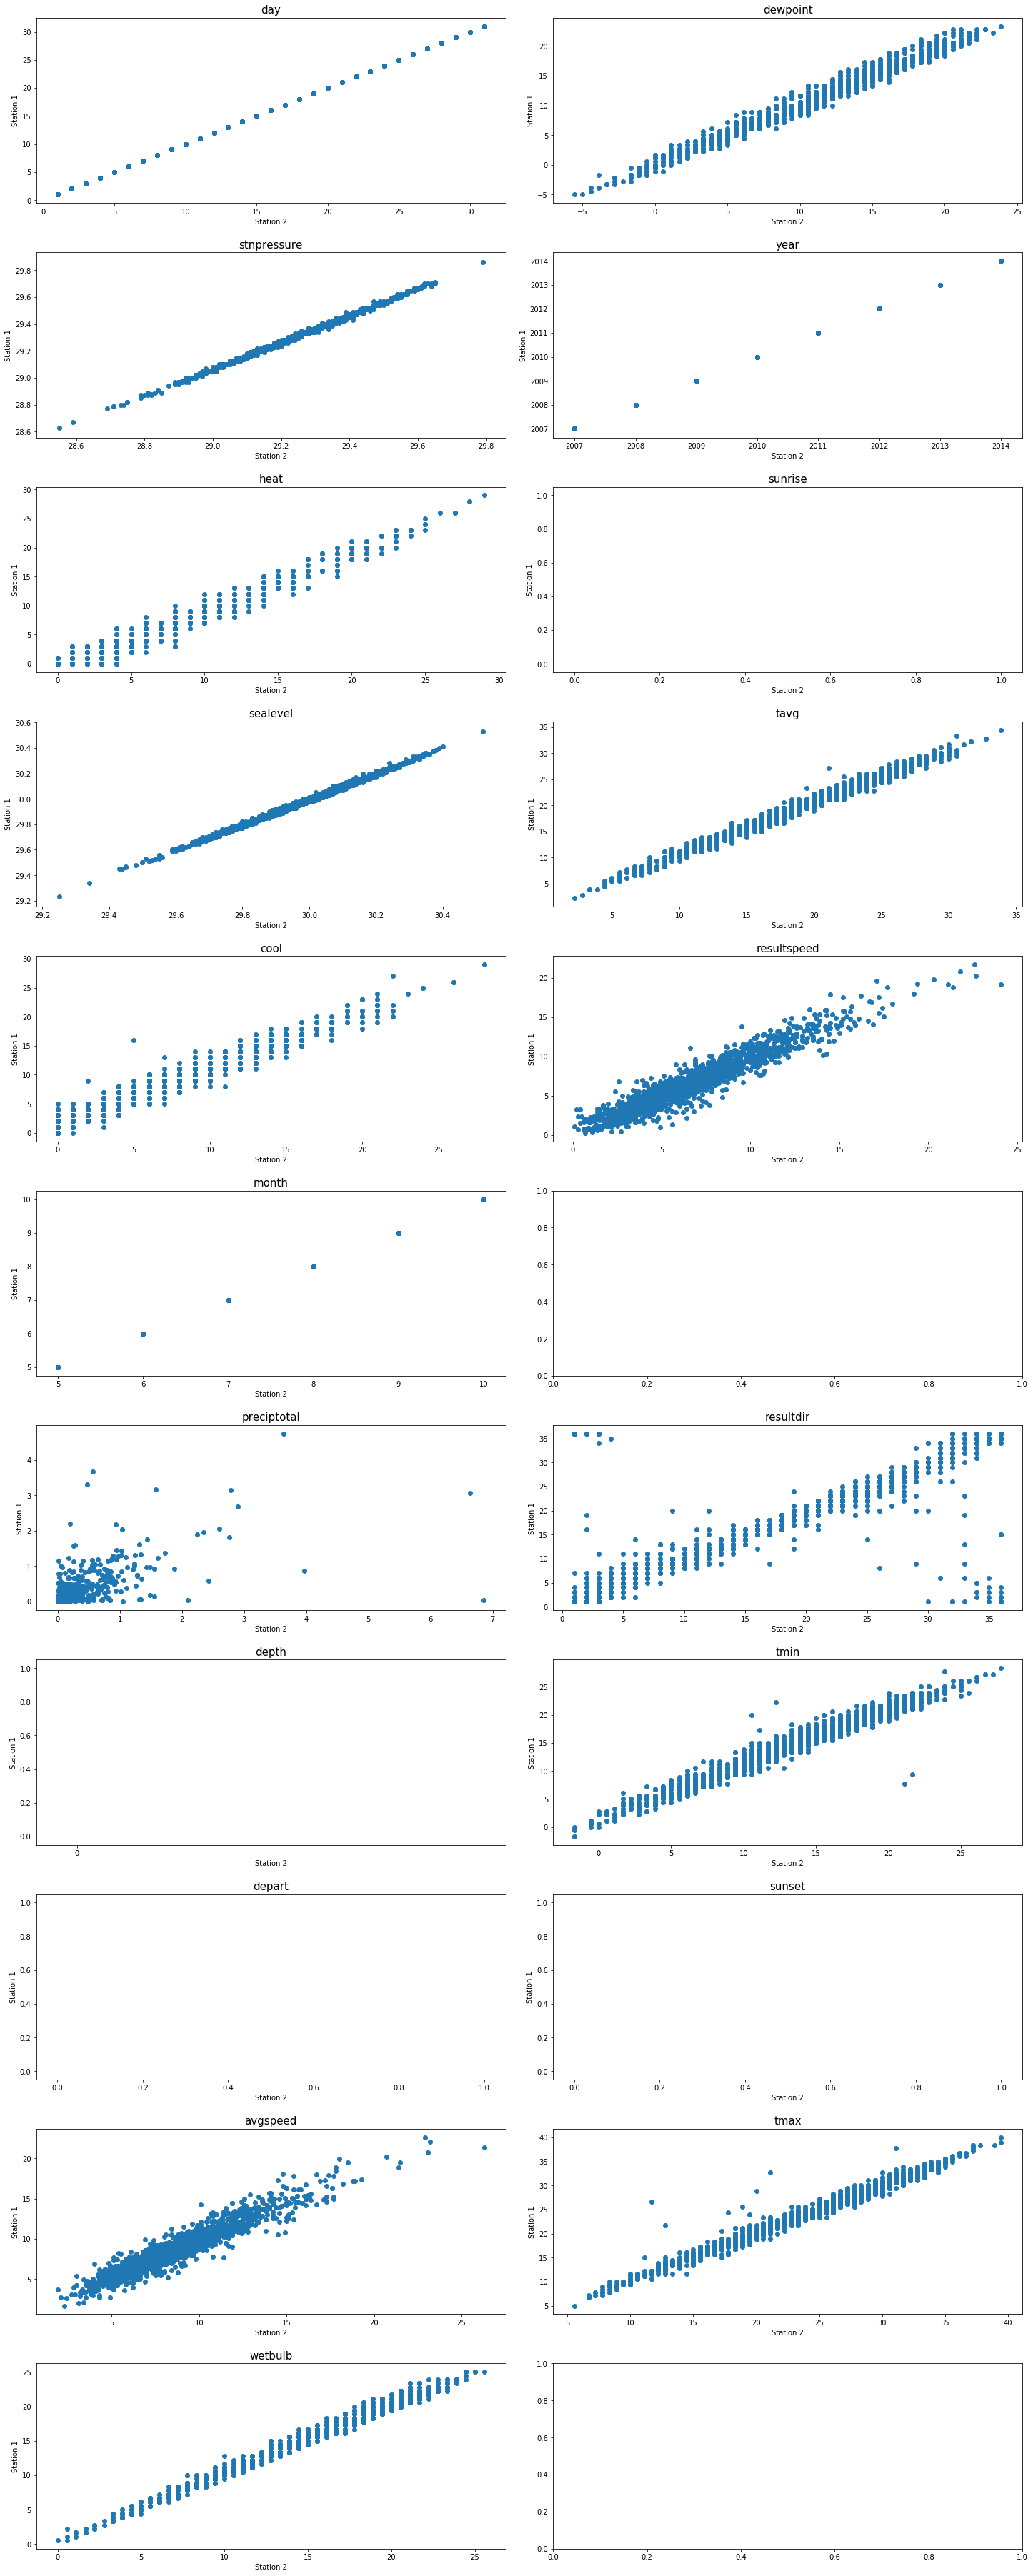

In [34]:
scatter(column_names)

**Comment**

As graphs above have shown, weather data from station 1 and station 2 are very similar.
However, station 1 has a lot less missing values. Therefore, the team's decision is to fill `nan` values in station 1 with information from station 2 and exclude station 2.

In [35]:
# Create dataframe subset of station 1 which only shows rows with `nan` values 
index_st1=df_weather_st1[df_weather_st1.isnull().any(axis=1)].index
df_weather_st1[df_weather_st1.isnull().any(axis=1)]

station       date   tmax   tmin   tavg  depart  dewpoint  wetbulb  \
416         1 2009-06-18  26.67  16.11  21.67  -17.22     17.22    19.44   
424         1 2009-06-26  30.00  20.56  25.56  -13.89     15.56      NaN   
497         1 2009-09-07  25.00  15.00  20.00  -17.22     15.00    16.67   
866         1 2011-09-08  23.89  13.89  18.89  -17.78     11.67    15.00   
878         1 2011-09-20  23.33   9.44  16.67  -17.78     12.22    14.44   
1045        1 2012-09-03  31.11  21.67  26.67  -11.11     21.11    22.78   
1205        1 2013-08-10  27.22  17.78  22.78  -17.78     13.89      NaN   
1206        1 2013-08-11  27.22  15.56  21.67  -18.89     16.11      NaN   

      heat  cool  ...  snowfall  preciptotal stnpressure sealevel resultspeed  \
416    0.0   6.0  ...       0.0         0.12       29.08      NaN         6.7   
424    0.0  13.0  ...       0.0         0.00         NaN    29.85         6.4   
497    0.0   3.0  ...       0.0         0.00       29.39      NaN         5.8   
866    0.0   1.0  ...       0.0         0.05       29.34      NaN        13.0   
878    3.0   0.0  ...       0.0         0.00       29.26      NaN         7.3   
1045   0.0  15.0  ...       0.0         0.00       29.17      NaN         4.6   
1205   0.0   8.0  ...       0.0         0.00         NaN    30.08         5.3   
1206   0.0   6.0  ...       0.0         0.01       29.35    30.07         2.0   

      resultdir  avgspeed  day  month  year  
416          16       7.9   18      6  2009  
424           4       8.2   26      6  2009  
497           3       4.0    7      9  2009  
866           2      13.4    8      9  2011  
878          18       7.3   20      9  2011  
1045          6       4.4    3      9  2012  
1205          5       6.5   10      8  2013  
1206         27       3.0   11      8  2013  

[8 rows x 24 columns]

In [36]:
# Find corresponding rows from station 2
df_weather_st2.loc[index_st1,:]

station       date   tmax   tmin   tavg  depart  dewpoint  wetbulb  \
416         2 2009-06-18  27.22  17.22  22.22     NaN     17.78    19.44   
424         2 2009-06-26  30.00  22.22  26.11     NaN     16.11    19.44   
497         2 2009-09-07  25.00  17.22  21.11     NaN     15.00    17.22   
866         2 2011-09-08  23.33  16.67  20.00     NaN     12.22    15.00   
878         2 2011-09-20  23.89  11.67  17.78     NaN     12.22    14.44   
1045        2 2012-09-03  30.56  22.78  26.67     NaN     20.56    22.78   
1205        2 2013-08-10  27.22  20.00  23.89     NaN     12.78    17.22   
1206        2 2013-08-11  28.89  17.22  23.33     NaN     13.89    17.78   

      heat  cool  ...  snowfall  preciptotal stnpressure sealevel resultspeed  \
416    0.0   7.0  ...       NaN         0.11       29.15    29.79         3.7   
424    0.0  14.0  ...       NaN         0.00       29.20    29.83         6.4   
497    0.0   5.0  ...       NaN         0.00       29.44    30.09         6.3   
866    0.0   3.0  ...       NaN         0.06       29.36    30.03        14.9   
878    1.0   0.0  ...       NaN         0.01       29.33    29.99         5.8   
1045   0.0  15.0  ...       NaN         0.00       29.23    29.87         5.0   
1205   0.0  10.0  ...       NaN         0.00         NaN    30.07         6.0   
1206   0.0   9.0  ...       NaN         0.05       29.42    30.06         4.0   

      resultdir  avgspeed  day  month  year  
416          17       5.8   18      6  2009  
424           4       8.0   26      6  2009  
497           4       6.9    7      9  2009  
866           2      15.2    8      9  2011  
878          17       6.1   20      9  2011  
1045          7       5.9    3      9  2012  
1205          6       7.4   10      8  2013  
1206         24       5.4   11      8  2013  

[8 rows x 24 columns]

In [37]:
# Filling NA in station 1 with info from station 2
df_weather_st1.loc[:,'wetbulb'].fillna(df_weather_st2['wetbulb'],inplace=True)
df_weather_st1.loc[:,'stnpressure'].fillna(df_weather_st2['stnpressure'],inplace=True)
df_weather_st1.loc[:,'sealevel'].fillna(df_weather_st2['sealevel'],inplace=True)

# NOTE: row with index 1205 has missing values in both stations. 
# It will be filled with information from the next day

df_weather_st1.loc[:,'stnpressure'].fillna(29.42,inplace=True);

C:\Users\junyu\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [38]:
# Check for any more null values in station 1
df_weather_st1.isnull().sum()

station        0
date           0
tmax           0
tmin           0
tavg           0
depart         0
dewpoint       0
wetbulb        0
heat           0
cool           0
sunrise        0
sunset         0
codesum        0
depth          0
snowfall       0
preciptotal    0
stnpressure    0
sealevel       0
resultspeed    0
resultdir      0
avgspeed       0
day            0
month          0
year           0
dtype: int64

**Comment**

External research showed that mosquitoe breeding activity is closely related to weather conditions from 2 weeks prior.
This might be related to their breeding cycles. Hence, we will be creating a new feature which indicates the weather condition from 2 weeks prior and also a humidity column based on the difference between the dry air temperature and the dew point temperature.

In [39]:
# Function to add feature which indicates humidity
def add_humidity(df):
    df['humidity'] = df['tavg'] - df['dewpoint']

In [40]:
add_humidity(df_weather_st1)

C:\Users\junyu\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
df_weather_st1

station       date   tmax   tmin   tavg  depart  dewpoint  wetbulb  \
0           1 2007-05-01  28.33  10.00  19.44  -10.00     10.56    13.33   
1           1 2007-05-02  15.00   5.56  10.56  -19.44      5.56     8.33   
2           1 2007-05-03  18.89   7.78  13.33  -16.67      4.44     8.89   
3           1 2007-05-04  18.89   9.44  14.44  -15.56      5.00    10.00   
4           1 2007-05-05  18.89  11.67  15.56  -15.00      3.33     9.44   
...       ...        ...    ...    ...    ...     ...       ...      ...   
1467        1 2014-10-27  25.00  10.56  17.78   -8.89     10.56    14.44   
1468        1 2014-10-28  20.00   7.22  13.89  -12.22      3.33     8.33   
1469        1 2014-10-29   9.44   2.22   6.11  -20.00      0.00     4.44   
1470        1 2014-10-30  10.56   0.00   5.56  -20.00      1.11     4.44   
1471        1 2014-10-31   8.33   0.56   4.44  -21.11     -3.89     0.56   

      heat  cool  ...  preciptotal  stnpressure sealevel resultspeed  \
0      0.0   2.0  ...         0.00        29.10    29.82         1.7   
1     14.0   0.0  ...         0.00        29.38    30.09        13.0   
2      9.0   0.0  ...         0.00        29.39    30.12        11.7   
3      7.0   0.0  ...         0.05        29.31    30.05        10.4   
4      5.0   0.0  ...         0.05        29.40    30.10        11.7   
...    ...   ...  ...          ...          ...      ...         ...   
1467   1.0   0.0  ...         0.00        28.92    29.66        12.0   
1468   8.0   0.0  ...         0.05        29.15    29.85        14.8   
1469  22.0   0.0  ...         0.00        29.36    30.06         9.5   
1470  23.0   0.0  ...         0.00        29.34    30.09         5.1   
1471  25.0   0.0  ...         0.03        29.49    30.20        22.6   

     resultdir  avgspeed  day  month  year  humidity  
0           27       9.2    1      5  2007      8.88  
1            4      13.4    2      5  2007      5.00  
2            7      11.9    3      5  2007      8.89  
3            8      10.8    4      5  2007      9.44  
4            7      12.0    5      5  2007     12.23  
...        ...       ...  ...    ...   ...       ...  
1467        19      12.9   27     10  2014      7.22  
1468        26      15.6   28     10  2014     10.56  
1469        29       9.9   29     10  2014      6.11  
1470        24       5.5   30     10  2014      4.45  
1471        34      22.9   31     10  2014      8.33  

[1472 rows x 25 columns]

### EDA - Spray dataset

**Comment**

We will be creating clusters to seperate the jobs done on each day when spraying was performed.

In [42]:
# Choosing columns for clustering
X = df_spray[['day', 'month','year','latitude', 'longitude']]

In [43]:
# Standardizing data
ss = StandardScaler()
X_scaled = ss.fit_transform(X)
# Training DBSCAN for prediction
dbs = DBSCAN(eps=0.4)
dbs.fit(X_scaled)

DBSCAN(algorithm='auto', eps=0.4, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [44]:
# Verifying labels (there should be 13)
np.unique(dbs.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [45]:
# Adding labels to spray df
df_spray['labels'] = dbs.labels_

In [46]:
df_spray.head()

date   latitude  longitude  day  month  year  labels
0 2011-08-29  42.391623 -88.089163   29      8  2011       0
1 2011-08-29  42.391348 -88.089163   29      8  2011       0
2 2011-08-29  42.391022 -88.089157   29      8  2011       0
3 2011-08-29  42.390637 -88.089158   29      8  2011       0
4 2011-08-29  42.390410 -88.088858   29      8  2011       0

In [47]:
# Plot out spray jobs to visually see clustering.

# Due to the time-consuming nature of the plotting, set 'on' to True to plot
# if cell output has been cleared.
on = False

if on:
    for uniqdate in list(df_spray['date'].unique()):
        df =  df_spray[df_spray['date']==uniqdate]
        f.gen_map()
        plt.scatter(x=df['longitude'],y=df['latitude'],c=df['labels'],cmap='Spectral')

**Comment**

Based on the plots above, there are some spray jobs which falls outside the area of Chicago.
Therefore, we will remove the irrelevant entries.

In [48]:
# Remove rows which falls outside area of interest
df_spray = df_spray.loc[df_spray['longitude'] > -88]

In [49]:
# Looking at result
clusteres_df = df_spray.groupby(['labels','date']).count()
clusteres_df.sort_values('date')

latitude  longitude   day  month  year
labels date                                              
1      2011-09-07      2114       2114  2114   2114  2114
2      2013-07-17       551        551   551    551   551
3      2013-07-17         5          5     5      5     5
4      2013-07-17      1646       1646  1646   1646  1646
5      2013-07-25      1607       1607  1607   1607  1607
6      2013-08-08      1195       1195  1195   1195  1195
7      2013-08-15      2668       2668  2668   2668  2668
       2013-08-16       141        141   141    141   141
8      2013-08-22       845        845   845    845   845
9      2013-08-22       742        742   742    742   742
10     2013-08-29      1371       1371  1371   1371  1371
11     2013-08-29       931        931   931    931   931
12     2013-09-05       924        924   924    924   924

#### Generate rectangular spray-affected regions based on the minimum and maximum latitude and longitude values for each spray job

In [50]:
# Defining min and max latitudes and longitudes for each cluster
min_spray = max_spray = df_spray.groupby('labels')[['date','latitude','longitude']].min()
max_spray = max_spray = df_spray.groupby('labels')[['latitude','longitude']].max()

In [51]:
# Merging min and max df in one
min_max_spray = pd.merge(min_spray,max_spray,on='labels')
# Renaming columns to make them more understandable
min_max_spray.columns = ['date', 'latitude_min', 'longitude_min', 'latitude_max', 'longitude_max'] 

In [52]:
min_max_spray

date  latitude_min  longitude_min  latitude_max  longitude_max
labels                                                                     
1      2011-09-07     41.968435     -87.836560     41.997028     -87.787710
2      2013-07-17     41.997728     -87.788258     42.015098     -87.762165
3      2013-07-17     41.972617     -87.871023     41.973142     -87.870150
4      2013-07-17     41.714098     -87.672362     41.743287     -87.629355
5      2013-07-25     41.939308     -87.739840     41.968097     -87.707987
6      2013-08-08     41.917227     -87.716847     41.946703     -87.678060
7      2013-08-15     41.887825     -87.818408     41.966532     -87.745625
8      2013-08-22     41.873487     -87.730655     41.895475     -87.701623
9      2013-08-22     41.713925     -87.623142     41.765277     -87.586727
10     2013-08-29     41.758812     -87.741315     41.786010     -87.694118
11     2013-08-29     41.976280     -87.698858     41.997808     -87.660885
12     2013-09-05     41.976773     -87.846338     42.018907     -87.789812

### EDA - Train dataset

In [53]:
df_train.head()

date                                            address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  species  block           street  trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              addressnumberandstreet   latitude  longitude  addressaccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   nummosquitos  wnvpresent  day  month  year  
0             1           0   29      5  2007  
1             1           0   29      5  2007  
2             1           0   29      5  2007  
3             1           0   29      5  2007  
4             4           0   29      5  2007

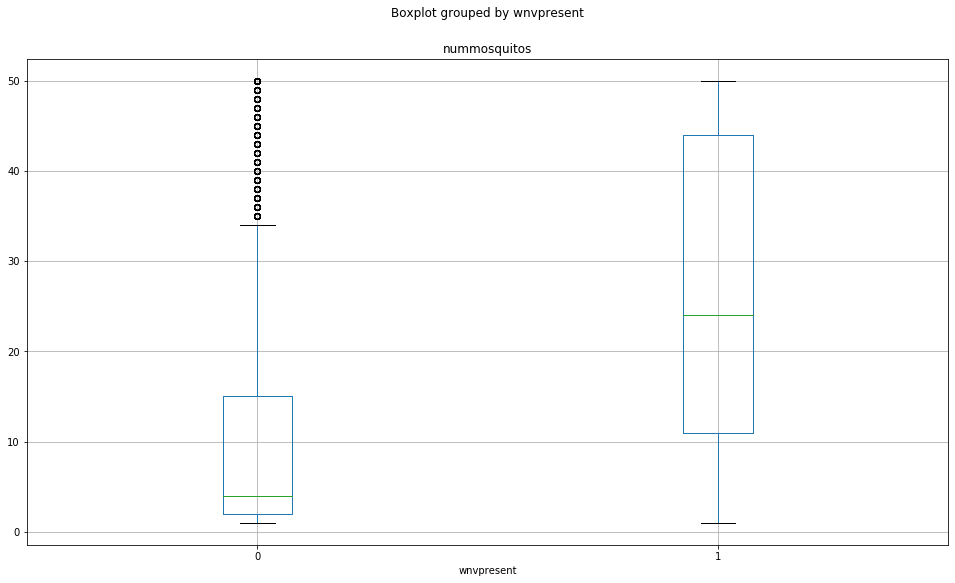

In [54]:
# Plot number of caught mosquitos against presence of virus
df_train.boxplot(by='wnvpresent',column='nummosquitos',figsize=(16,9));

**Comment**

Based on the comments above, virus is present when number of mosquitos is high.

However, it is important to note that these test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), 

Therefore, each row may be a subgroup which is capped at 50 mosquitoes.

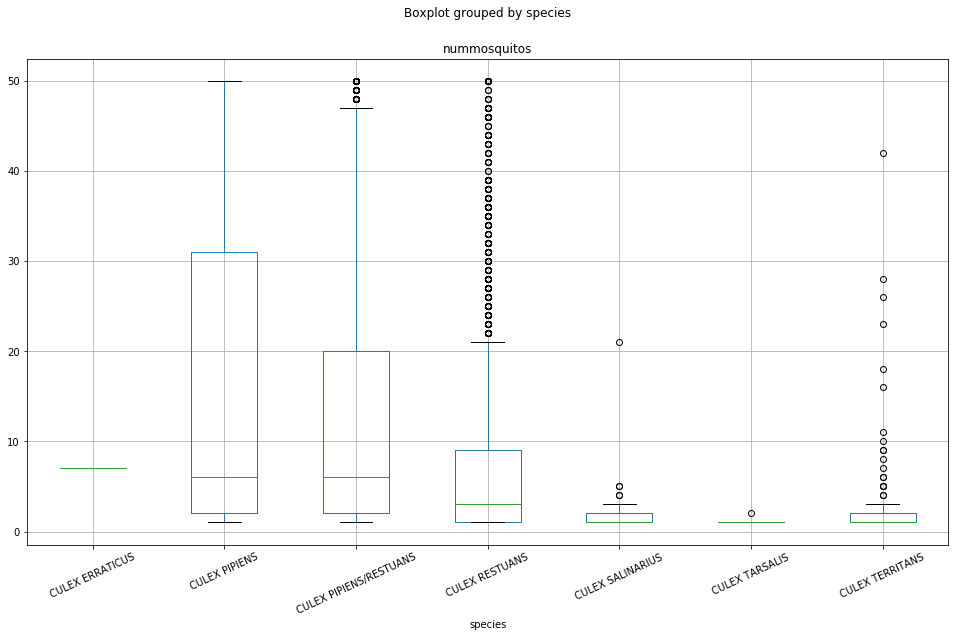

In [55]:
# Plot species of mosquitos against number of mosquitoes
df_train.boxplot(by='species',column='nummosquitos',rot=25, figsize=(16,9));

In [56]:
df_train['species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: species, dtype: int64

**Comment**

3 species of mosquitos caught much more frequently than the others - Culex Pipiens, Culex Restuans and Culex Pipiens/Restuans

Records exist only when a particular species of mosquitos is found at a certain trap at a certain time. 

Date: date that the WNV test is performed

In [57]:
# Tabulate NumMosquitos and WnvPresent by species
df_train.groupby('species')[['nummosquitos','wnvpresent']].sum()

nummosquitos  wnvpresent
species                                         
CULEX ERRATICUS                    7           0
CULEX PIPIENS                  44671         240
CULEX PIPIENS/RESTUANS         66268         262
CULEX RESTUANS                 23431          49
CULEX SALINARIUS                 145           0
CULEX TARSALIS                     7           0
CULEX TERRITANS                  510           0

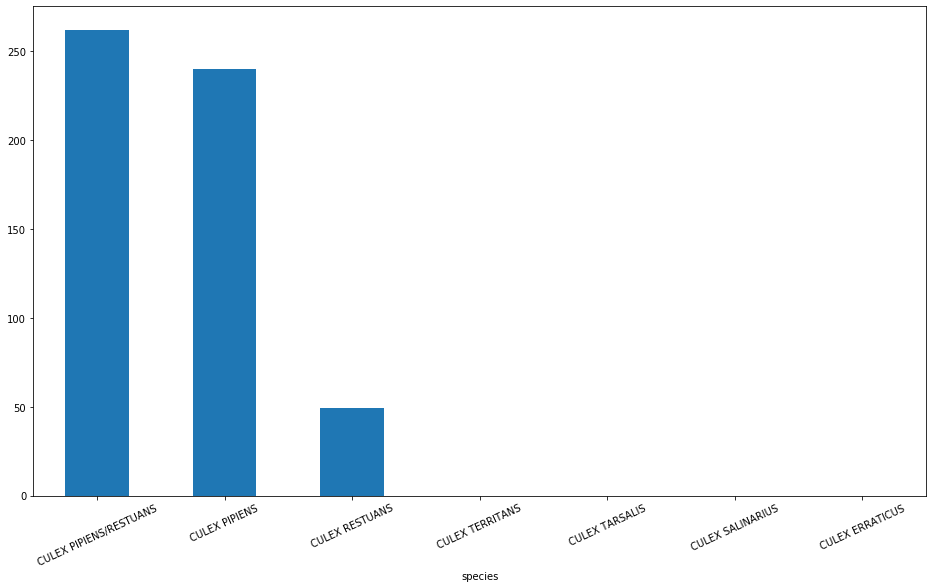

In [58]:
# Plot Mosquitoe species against counts of WNV presence
df_train.groupby('species')['wnvpresent'].sum().sort_values(ascending=False).plot.bar(figsize=(16,9),rot=25);

**Comment**

Based on the above, only mosquitoes which are of the species Culex Pipiens, Culex Pipiens/Restuans and Culex Restuans will carry the West Nile Virus. Therefore, a new boolean feature which indicates whether the mosquitoes caught in each trap are of these few species is created.

In [59]:
# Creating new column which indicates whether mosquitoes caught in the trap have the virus
df_train['iswnvspecies'] = df_train['species'].str.contains('PIPIENS|RESTUANS').astype(int)
df_test['iswnvspecies'] = df_test['species'].str.contains('PIPIENS|RESTUANS').astype(int)

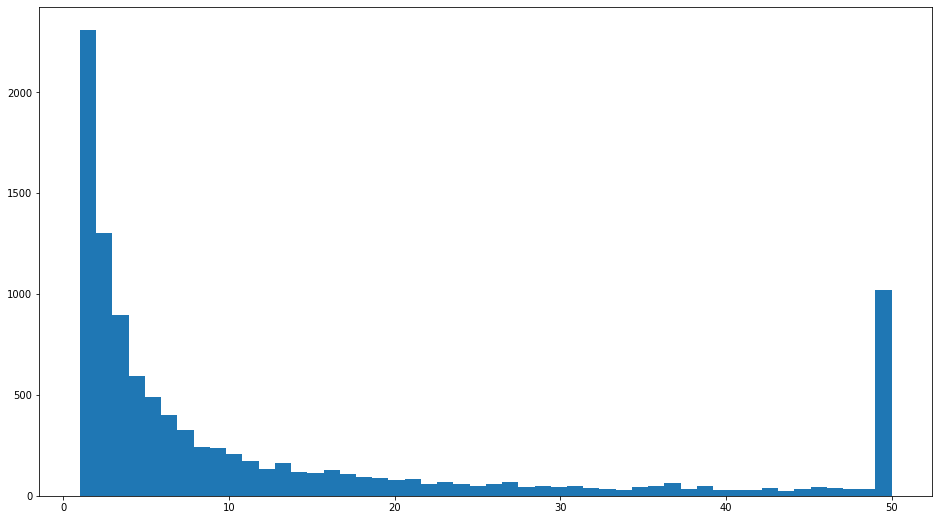

In [60]:
# Plot histogram of nummosquitos
plt.figure(figsize=(16,9))
plt.hist(data=df_train,x='nummosquitos',bins=50);

**Comment**

Based on the plot above, a high number of entries has very few mosquitoes. But, there are also many entries which has 50 mosquitoes. This would indicate that these traps are catching more than 50 mosquitoes in a day.

In [61]:
# Get top 10 traps with highest occurance of West Nile Virus
top10 = df_train.groupby('trap')['wnvpresent','nummosquitos'].mean().sort_values(by='wnvpresent',ascending=False)
top10.head(10)

C:\Users\junyu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


wnvpresent  nummosquitos
trap                           
T143     0.193548      7.419355
T006     0.166667      4.458333
T005     0.142857      3.571429
T233     0.140000     15.160000
T014     0.133333     12.133333
T096     0.120000     11.560000
T003     0.114754     11.032787
T015     0.114286      4.828571
T235     0.112903      8.983871
T054C    0.111111     16.111111

#### Merge df_train by date, followed by by trap to get total number of moquitoes per trap per day

###### Some of the following cells are commented out as the final output has been saved to a csv file for time saving.

In [62]:
# df_train_groupbydate_trap = df_train.groupby(['date','trap'])

In [63]:
def chkWNV(series):
    return 1 if series.sum() > 0 else 0

In [64]:
# Merge by Date, followed by Trap
def mergebydate_time():
    df_merged = pd.DataFrame(columns=['date', 'address', 'species',
                                      'block', 'street', 'trap',
                                      'addressnumberandstreet',
                                      'latitude', 'longitude',
                                      'addressaccuracy',
                                      'nummosquitos', 'wnvpresent'])

    for date_trap, df in df_train_groupbydate_trap:
        df_merged.loc[len(df_merged)] = [date_trap[0],
                                         np.unique(df['address'])[0],
                                         np.unique(df['species']),
                                         np.unique(df['block'])[0],
                                         np.unique(df['street'])[0],
                                         date_trap[1], 
                                         np.unique(df['addressnumberandstreet'])[0], 
                                         np.unique(df['latitude'])[0],
                                         np.unique(df['longitude'])[0],
                                         np.unique(df['addressaccuracy'])[0],
                                         sum(df['nummosquitos']),
                                         chkWNV(df['wnvpresent'])]
    return df_merged

In [65]:
def add_ispraycol(df):
    df['is_spray'] = False

    tdelta_min = dt.timedelta(days=0)
    tdelta_max = dt.timedelta(days=30)

    # Looping through df with min,max latitudes and longitudes
    for i,spray in min_max_spray.iterrows():
        long_min = spray['longitude_min']
        long_max = spray['longitude_max']
        lat_min = spray['latitude_min']
        lat_max = spray['latitude_max']

    # Looping through train df, checking is latitudes and longitudes lay between min and max
    # and date is the same date or date +30 days of spraying 
        for j,row in df.iterrows():
            if (tdelta_min < (row['date']-spray['date']) <=tdelta_max):
                if ((lat_min <= row['latitude'] <= lat_max) &
                    (long_min <= row['longitude'] <= long_max)):
                    df.loc[j,'is_spray'] = True

In [66]:
# df_train_bydate_trap = mergebydate_time()

In [67]:
# df_train_bydate_trap.head()

In [68]:
# df_train_bydate_trap['date'] = pd.to_datetime(df_train_bydate_trap['date'])

In [69]:
# df_train_bydate_trap['species'] = df_train_bydate_trap['species'].apply(','.join)

In [70]:
# df_train_bydate_trap['iswnvspecies'] = df_train_bydate_trap['species'].str.contains('PIPIENS|RESTUANS').astype(int)

In [71]:
# add_ispraycol(df_train_bydate_trap)

In [72]:
# df_train_bydate_trap.to_csv('../datasets/df_train_bydate_trap.csv', index=False)

In [73]:
df_train_bydate_trap = pd.read_csv('../datasets/df_train_bydate_trap.csv',)

In [74]:
df_train_bydate_trap['date'] = pd.to_datetime(df_train_bydate_trap['date'])

In [75]:
df_train_bydate_trap['nummosquitos'].describe().T

count    4616.000000
mean       29.254549
std       118.533327
min         1.000000
25%         3.000000
50%         7.000000
75%        20.000000
max      3002.000000
Name: nummosquitos, dtype: float64

In [76]:
df_train_bydate_trap[df_train_bydate_trap['is_spray']==1].loc[:,['trap']]['trap'].unique()

array(['T223', 'T008', 'T009', 'T089', 'T094', 'T094B', 'T159', 'T233',
       'T236', 'T228', 'T147', 'T002', 'T003', 'T013', 'T017', 'T151',
       'T222', 'T230', 'T080', 'T083', 'T102', 'T227', 'T066', 'T231',
       'T028'], dtype=object)

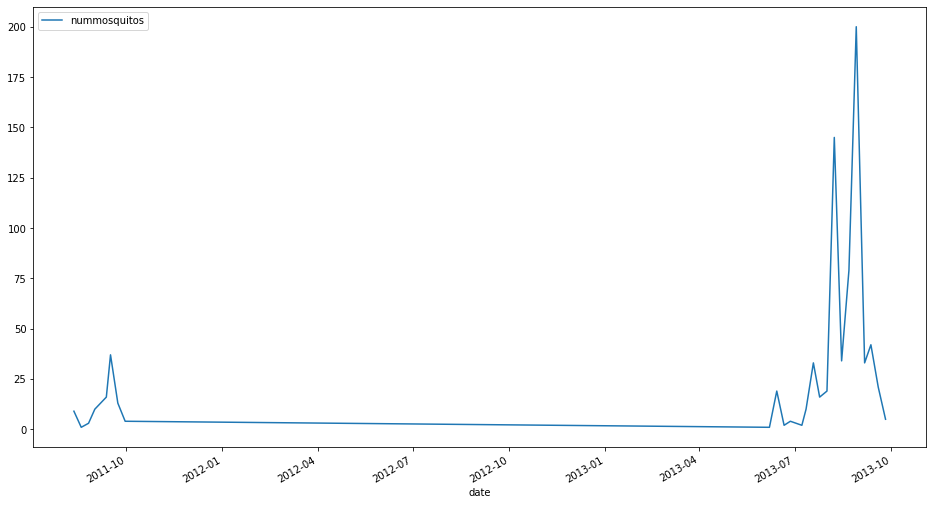

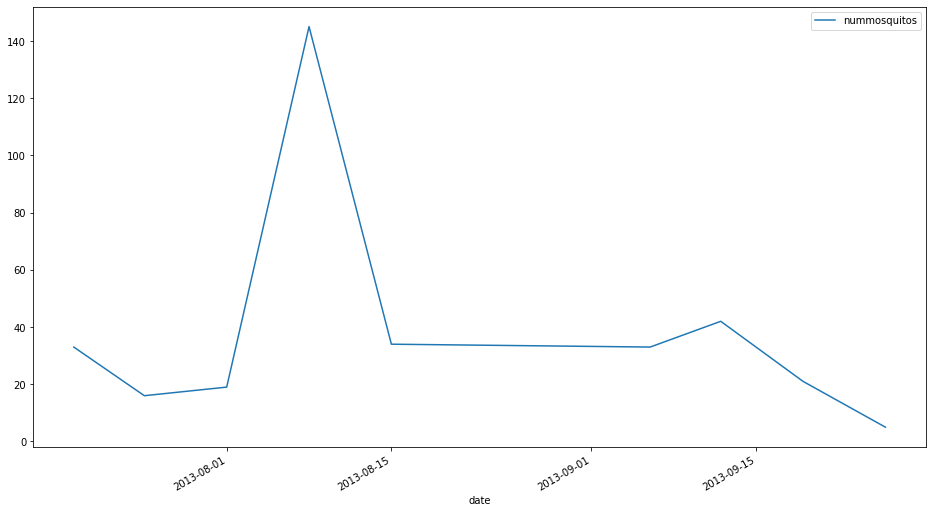

In [77]:
test_df = df_train_bydate_trap[df_train_bydate_trap['trap']=='T233']
test_df.plot(x='date',y='nummosquitos',figsize=(16,9))
test_df[test_df['is_spray']==1].plot(x='date',y='nummosquitos',figsize=(16,9));

In [78]:
df_totalmos = df_train_bydate_trap[df_train_bydate_trap['nummosquitos']>2000]

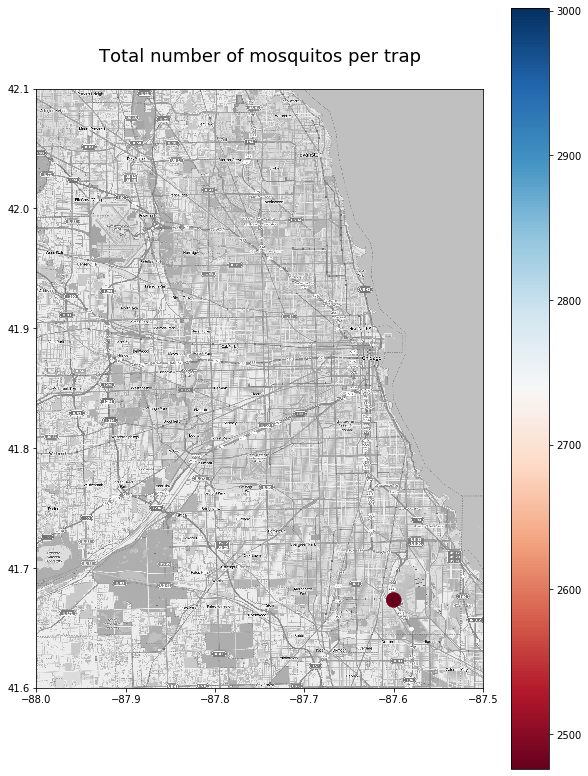

In [79]:
f.gen_map()

plt.scatter(x=df_totalmos['longitude'],
            y=df_totalmos['latitude'],
            c=df_totalmos['nummosquitos'], 
            cmap = 'RdBu',
            s=200,
            alpha = 1,
            marker='o')

plt.title('Total number of mosquitos per trap\n',fontsize=18)
plt.colorbar()
plt.show();

#### Temporarily merge df_train and df_weather for EDA

In [80]:
# Create temporary dataframe by merging cleaned df_train and df_weather dataframes
df = pd.merge(df_train, df_weather_st1, on="date")

# Select a few columns for analysis
df = df[['date', 'nummosquitos', 'species', 'tavg', 'wnvpresent', 'sealevel', 'dewpoint', 'wetbulb', 'preciptotal', 'stnpressure']]

# Create another temporary variable, this is the mean temperature, mosquitos and wnv present
df_mean = df.groupby(['date']).mean()

# Segregate species that carry WNV or not
df['wnvspecies'] = [1 if ('PIPIENS' or 'RESTUANS') in row else 0 for row in df['species']]

# Segregate Non-Pipiens / Restuans (0), Pip&Rest w/o WNV (1), Pip&Rest with WNV (0)
df['3cat'] = df['wnvspecies'] + df['wnvpresent']

# Create 2 temporary dataframes to categorise data by month (average for weather, total for mosquito and virus data)
df_date = df.groupby('date')['nummosquitos','wnvpresent'].sum()
df_temp = df.groupby('date')['tavg','wetbulb'].mean()
df_date['tavg'] = df_temp['tavg']
df_date['wetbulb'] = df_temp['wetbulb']

df_date_month = df_date.groupby(by=[df_date.index.month])['nummosquitos','wnvpresent'].sum()
df_temp_month = df_date.groupby(by=[df_date.index.month])['tavg','wetbulb'].mean()
df_date_month['tavg'] = df_temp_month['tavg']
df_date_month['wetbulb'] = df_temp_month['wetbulb']

C:\Users\junyu\anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\junyu\anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\junyu\anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\junyu\anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


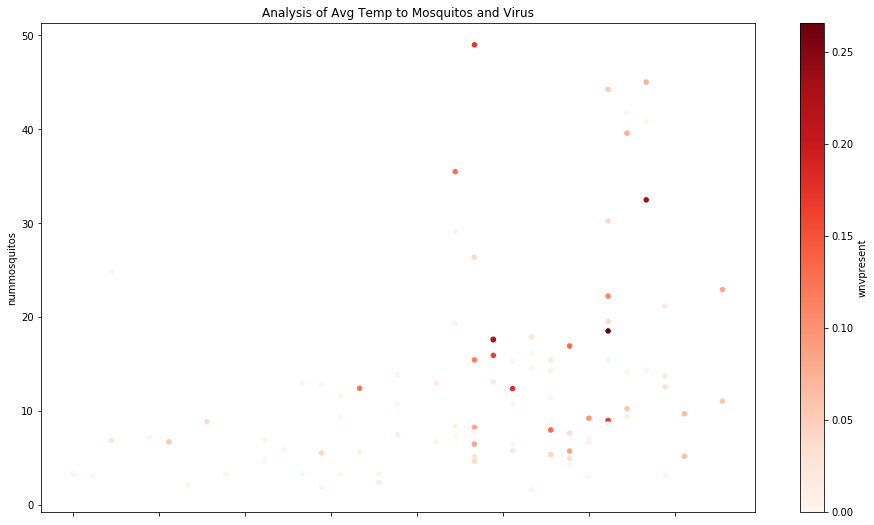

In [81]:
# Higher Temperature = More Mosquitos = Higher weightage of WNV Present

df_mean.plot.scatter(x='tavg', y='nummosquitos', c='wnvpresent', colormap='Reds',figsize=(16,9))
plt.title('Analysis of Avg Temp to Mosquitos and Virus');

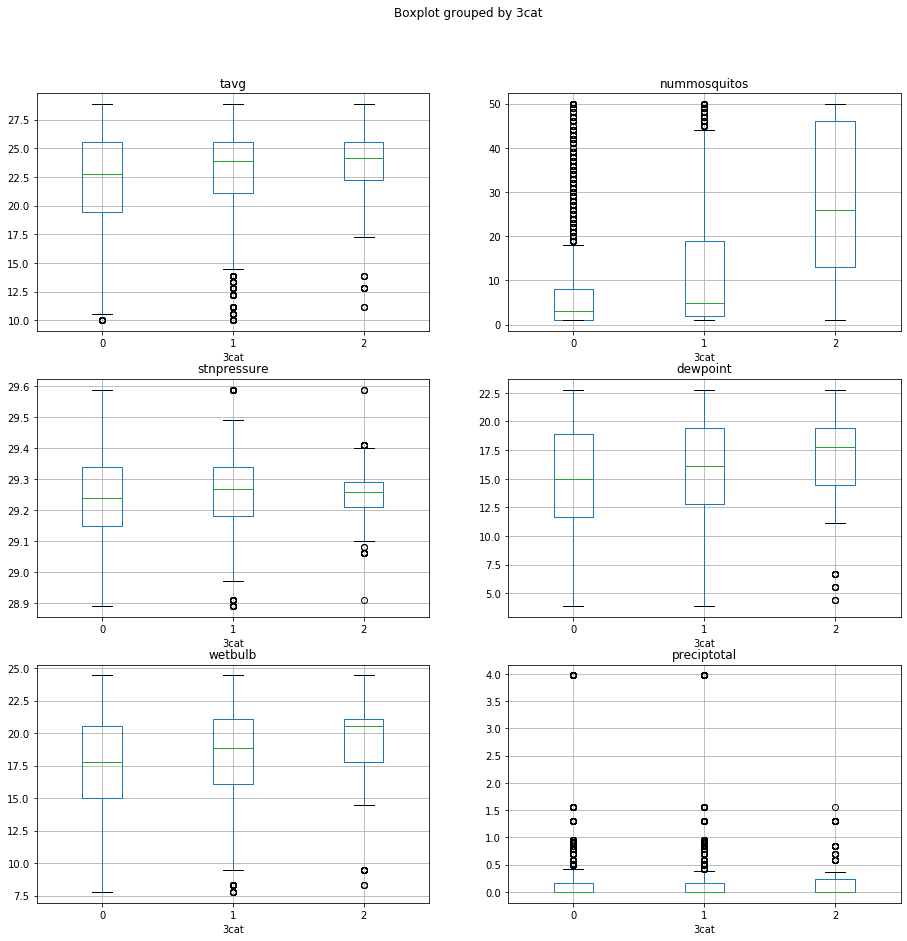

In [82]:
# Category labels:
# 0 [Non-Pipiens & Restuans (Statistically 0 WNV Present)]
# 1 [Pipiens & Restuans with NO WNV]
# 2 [Pipiens & Restuans WITH WNV]

fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(15,15)) 

df.boxplot(column='tavg', by='3cat', ax=axes[0,0]) 
df.boxplot(column='nummosquitos', by='3cat', ax=axes[0,1]) 
df.boxplot(column='stnpressure', by='3cat', ax=axes[1,0]) 
df.boxplot(column='dewpoint', by='3cat', ax=axes[1,1]) 
df.boxplot(column='wetbulb', by='3cat', ax=axes[2,0]) 
df.boxplot(column='preciptotal', by='3cat', ax=axes[2,1]) 

plt.show()

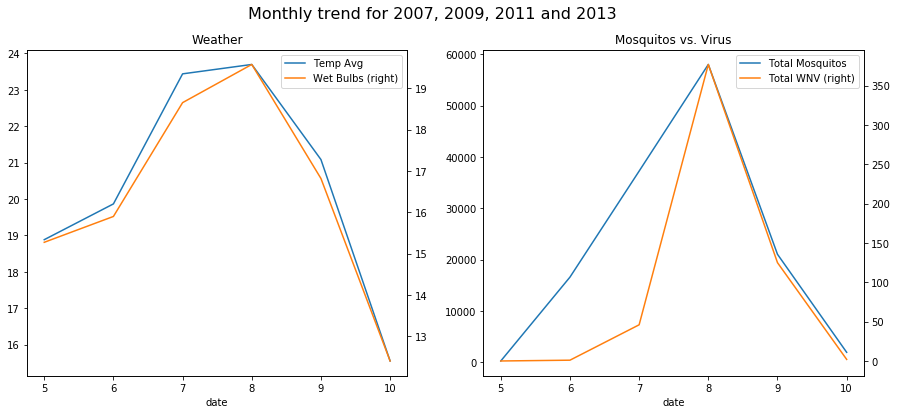

In [83]:
# Month by month analysis for training dataset

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,6))

fig.suptitle("Monthly trend for 2007, 2009, 2011 and 2013", fontsize=16)
df_date_month.tavg.plot(label="Temp Avg", legend=True, ax=axes[0])
df_date_month.wetbulb.plot(secondary_y=True, label="Wet Bulbs", legend=True, ax=axes[0])
axes[0].set_title('Weather')

df_date_month.nummosquitos.plot(label='Total Mosquitos', legend=True,  ax=axes[1]) 
df_date_month.wnvpresent.plot(label='Total WNV', legend=True, ax=axes[1], secondary_y=True)
axes[1].set_title('Mosquitos vs. Virus')

plt.show()

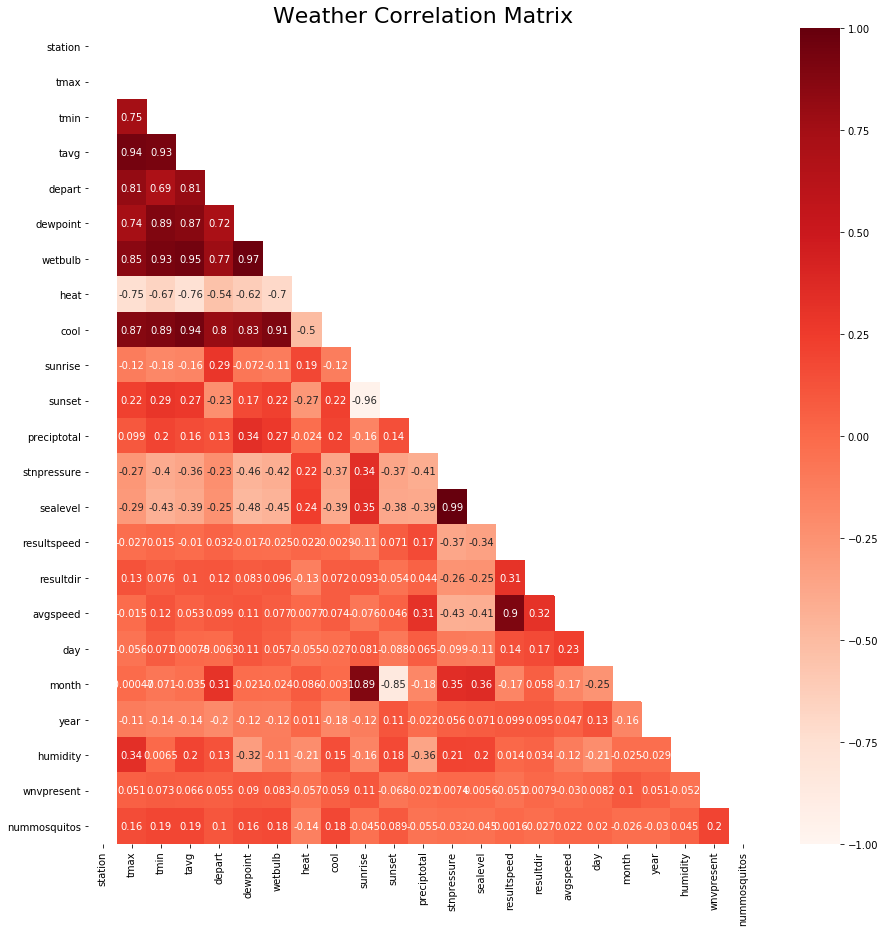

In [84]:
# Merge final weather set df_weather_st1, with df_train for specific columns that would be needed to perform EDA 
weather_eda1 = pd.merge(df_weather_st1, df_train[['date','species','wnvpresent','nummosquitos']], on='date')
numeric_df = weather_eda1._get_numeric_data()
# Setting up the size of the figure
plt.figure(figsize=(15,15))
# Insert the title 
plt.title("Weather Correlation Matrix", fontsize=22) 
corr = numeric_df.corr()
# Set up mask to be True to hide upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
heat_map = sns.heatmap(corr,mask=mask,annot=True,vmin=-1,vmax=1,cmap="Reds")

Looking at the correlation matrix above, we notice there's a high degree of collinearity between a number of features.
By analyzing the heatmap, we can see;

- Average Sealevel is highly correlated with Average Station Pressure at 0.99 (highest)
- However, both Sealevel and Station Pressure are inversely correlated to most of the other features in the dataset, except for Heat and Sunrise.
- At the top of the map, we notice Temperature features(Min, Max and Avg) are highly correlated between Depart, Dewpoint and Wetbulb.
- The top 5 features with positive correlation to WnvPresent are Dewpoint, Wetbulb, Temperature Min, Temperature Average and Depart.

C:\Users\junyu\anaconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


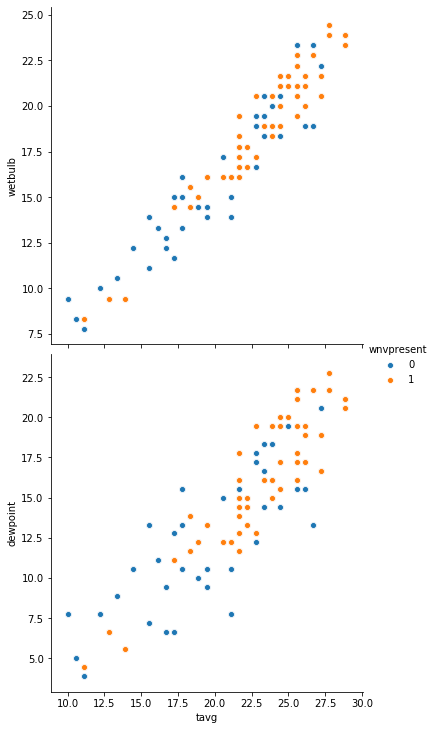

In [85]:
sns.pairplot(data=weather_eda1, x_vars='tavg', y_vars=['wetbulb', 'dewpoint'],
             hue='wnvpresent', size=5)

- Looking further into the relationship between WnvPresent, Average Temperature, Dewpoint and Wetbulb.
- We could see the positive correlation, as the graph above shows when Average Temperature is above 20 degrees there's an increase in number of WnvPresent while for Wetbulb it is 16 deg celsius.
- For Dewpoint the graph shows when its above 12 degrees, there will be an increase in WnvPresent.

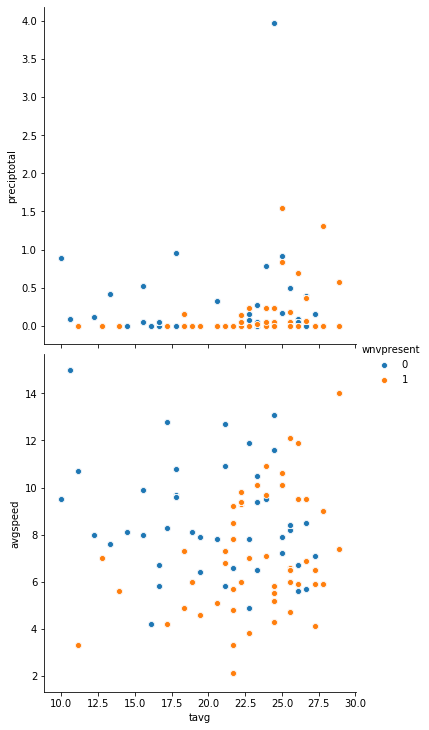

In [86]:
sns.pairplot(data=weather_eda1, x_vars='tavg', y_vars=['preciptotal', 'avgspeed'],
             hue='wnvpresent', size=5)

- Looking at the precipitation graph, shows there's very little to no correlation between Average Temperature and WnvPresent. The number of WnvPresent is increasing only due to rise in Average Temperature while Precipitation remains near 0.
- 

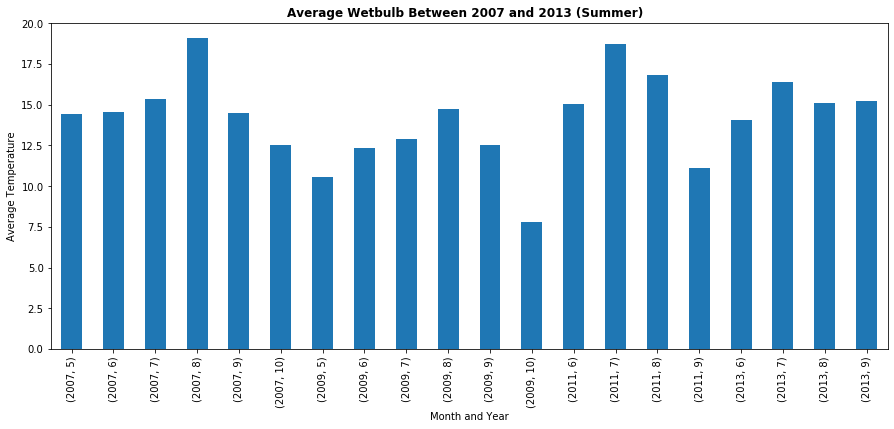

In [87]:
# Overview of average temperature across the summer months of 2007 to 2013
weather_eda1.groupby(['year','month']).dewpoint.mean().plot(kind='bar', figsize=(15,6))
plt.title('Average Wetbulb Between 2007 and 2013 (Summer)  ', weight= 'bold')
plt.grid(False)
plt.xlabel('Month and Year')
plt.ylabel('Average Temperature')
plt.show()

- Year over year, we notice from the bar chart above July and August are the hottest months during summer.
- In 2009, there was drop in average temperature during the summer months (May-October) compared to 2007.
- This was due to above then normal rainfalls, presistent cloudiness and cooling winds from Lake Michigan

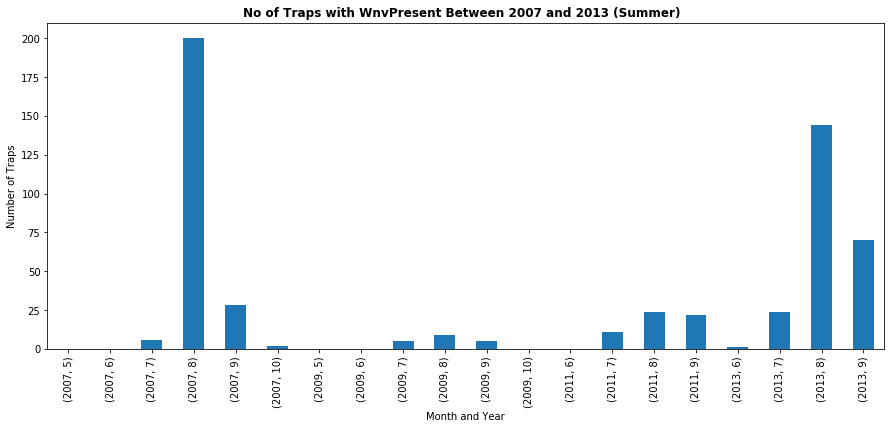

In [88]:
# Overview of the number of traps with WnvPresent across the summer months from 2007 to 2013
weather_eda1.groupby(['year','month']).wnvpresent.sum().plot(kind='bar', figsize=(15,6))
plt.title('No of Traps with WnvPresent Between 2007 and 2013 (Summer)  ', weight= 'bold')
plt.grid(False)
plt.xlabel('Month and Year')
plt.ylabel('Number of Traps')
plt.show()

- As mention above, the summer months of 2009 saw a cold front which came in from Lake Michigan causing it to have abnormal weather from May to August. This might have played a major to containing the number of moquistos carrying the virus.
- However, in 2011 we only see a slight increase in number of traps with WnvPresent despite temperatures going back to their normal range.
- The number of traps began to rise only 2 years later, in the summer of 2013. Will be checking to see if their any external factors that might have contributed to the decrease in traps.

### EDA - Combined dataset

In [89]:
# Creating a new column is_spray and setting all cells as False
df_train['is_spray'] = False
df_test['is_spray'] = False

In [90]:
# Very slow cell,change on to False if not running it
# Setting time delta as 30 days.
# A typical mosquito treatment lasts about 30 days. 
# https://www.callnorthwest.com/2019/05/how-long-does-a-mosquito-treatment-last/
on=False
if on:
    tdelta_min = dt.timedelta(days=0)
    tdelta_max = dt.timedelta(days=30)
    
    for df in [df_train,df_test]:
        # Looping through df with min,max latitudes and longitudes
        for i,spray in min_max_spray.iterrows():
            long_min = spray['longitude_min']
            long_max = spray['longitude_max']
            lat_min = spray['latitude_min']
            lat_max = spray['latitude_max']
        # Looping through train df, checking is latitudes and longitudes lay between min and max
        # and date is the same date or date +30 days of spraying 
            for j,row in df_train.iterrows():
                if (tdelta_min < (row['date']-spray['date']) <=tdelta_max):
                    if ((lat_min <= row['latitude'] <= lat_max) &
                        (long_min <= row['longitude'] <= long_max)):
                        df_train.loc[j,'is_spray'] = True

In [91]:
# Checking number of rows in train which were sprayed - train
df_train['is_spray'].value_counts()

False    10506
Name: is_spray, dtype: int64

In [92]:
# Checking number of rows in train which were sprayed - test
df_test['is_spray'].value_counts()

False    116293
Name: is_spray, dtype: int64

In [93]:
# Merging weather and train df
main_df = pd.merge(df_train,df_weather_st1, on=['date','year','month','day'])
main_df_test = pd.merge(df_test,df_weather_st1, on=['date','year','month','day'])

In [94]:
main_df.isnull().sum()

date                      0
address                   0
species                   0
block                     0
street                    0
trap                      0
addressnumberandstreet    0
latitude                  0
longitude                 0
addressaccuracy           0
nummosquitos              0
wnvpresent                0
day                       0
month                     0
year                      0
iswnvspecies              0
is_spray                  0
station                   0
tmax                      0
tmin                      0
tavg                      0
depart                    0
dewpoint                  0
wetbulb                   0
heat                      0
cool                      0
sunrise                   0
sunset                    0
codesum                   0
depth                     0
snowfall                  0
preciptotal               0
stnpressure               0
sealevel                  0
resultspeed               0
resultdir           

In [95]:
# Saving clean datasets
main_df.to_csv('../datasets/main_df.csv',index=False)
main_df_test.to_csv('../datasets/main_df_test.csv',index=False)

In [96]:
# For faster perfomance of the notebook do not run all the cells above, just upload clean Datasets (train and test)

In [97]:
# Uploading clean datasets
main_df = pd.read_csv('../datasets/main_df.csv')
main_df_test = pd.read_csv('../datasets/main_df_test.csv')
# Changing date columns to datetime type
main_df['date'] = pd.to_datetime(main_df['date'])
main_df_test['date'] = pd.to_datetime(main_df_test['date'])

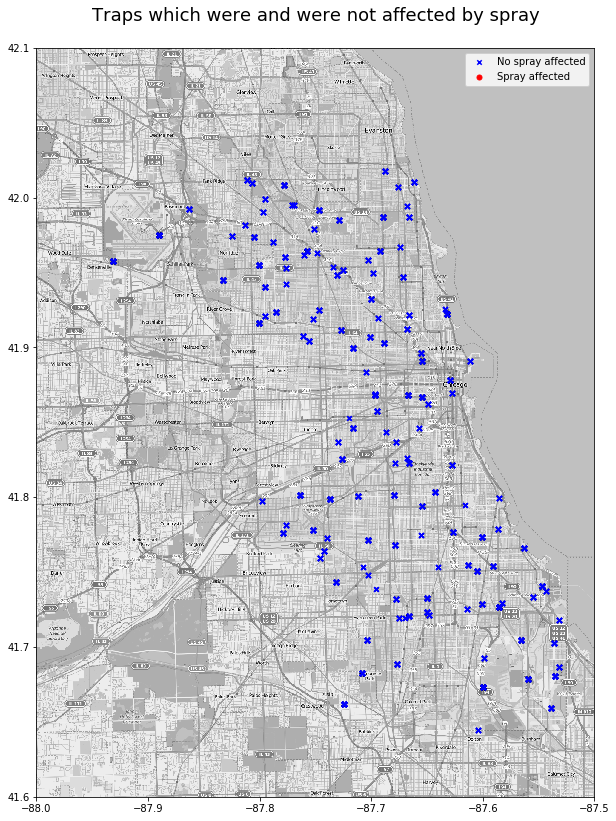

In [98]:
# Plotting traps which were and were not affected by spray
spray_traps = main_df[main_df['is_spray']==True]
spray_no_traps = main_df[main_df['is_spray']==False]

lats_spray = spray_traps['latitude']
longs_spray = spray_traps['longitude']
lats_no_spray = spray_no_traps['latitude']
longs_no_spray = spray_no_traps['longitude']

f.gen_map()

plt.scatter(x=longs_no_spray, y=lats_no_spray, c='b', s=20, marker='x',label='No spray affected')
plt.scatter(x=longs_spray, y=lats_spray, c='r', s=25,label='Spray affected')
plt.title('Traps which were and were not affected by spray\n',fontsize=18)
plt.legend()
plt.show();

**Comment**

From the map above it is seen that only some areas were affected by spray.

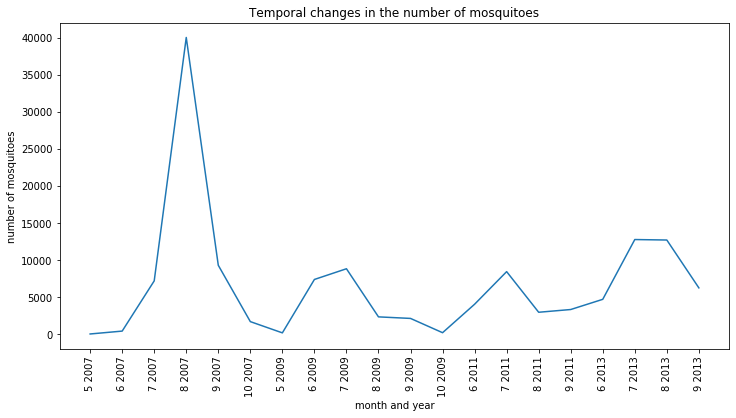

In [99]:
# Visualisation of temporal trend of number of mosquitoes 
main_df['month'] = main_df['date'].map(lambda x: x.month)
num_mosq_month = main_df.groupby(['year','month'])['nummosquitos'].sum().reset_index(level=[0,1])
plt.figure(figsize=(12,6))
plt.plot(num_mosq_month['nummosquitos'])
plt.xticks(range(len(num_mosq_month)),
labels=list(num_mosq_month['month'].astype('str')+' '+num_mosq_month['year'].astype('str')),
          rotation='vertical')
plt.title('Temporal changes in the number of mosquitoes');
plt.ylabel('number of mosquitoes')
plt.xlabel('month and year');

**Comment**

From the linegraph it can be seen that the train dataset contain information only about 5th,6th,7th,8th,9th and 10th months of 2007,2009,2011 and 2013 years.

The biggest numbers of mosquitoes are in 7th and 8th each year.

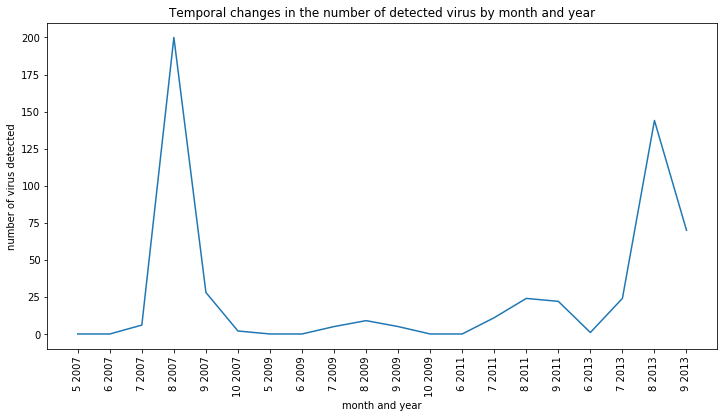

In [100]:
# Plot total count of traps with virus per month over time
num_mosq_month = main_df.groupby(['year','month'])['wnvpresent'].sum().reset_index(level=[0,1])
plt.figure(figsize=(12,6))
plt.plot(num_mosq_month['wnvpresent'])
plt.xticks(range(len(num_mosq_month)),
labels=list(num_mosq_month['month'].astype('str')+' '+num_mosq_month['year'].astype('str')),
          rotation='vertical')
plt.title('Temporal changes in the number of detected virus by month and year');
plt.ylabel('number of virus detected')
plt.xlabel('month and year');

**Comment**

The linegraph illustrate that high number of virus was detected in month 8.

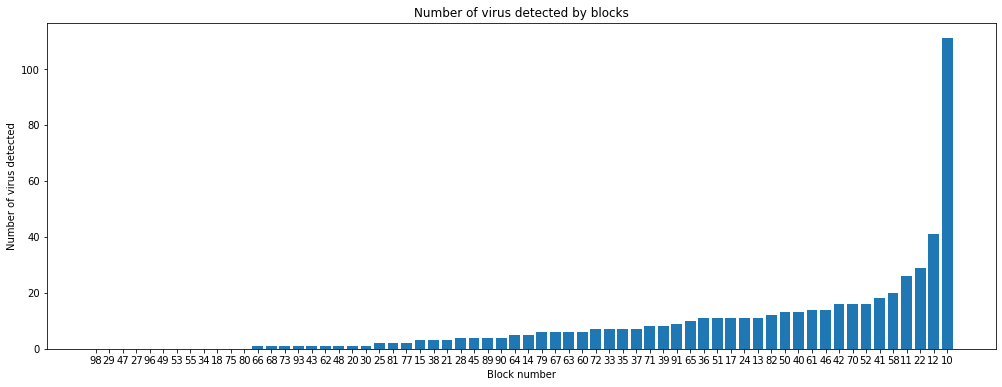

In [101]:
# Plotting presence of the virus on each block
plt.figure(figsize=(17,6))
block_virus = main_df.groupby('block')['wnvpresent'].sum().sort_values()
plt.bar(range(len(main_df['block'].unique())), block_virus)
plt.xlabel('Block number')
plt.ylabel('Number of virus detected')
plt.title('Number of virus detected by blocks')
plt.xticks(range(len(main_df['block'].unique())),labels=block_virus.index);

**Comment**

The bar graph showed that in traps located in block 10, the virus was detected much frequently than in other locations.

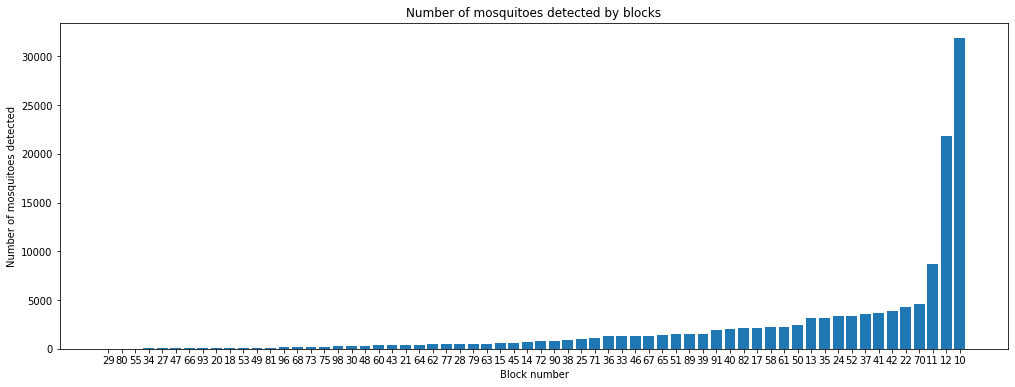

In [102]:
# Plotting number of mosquitoes caught on each block
plt.figure(figsize=(17,6))
plt.bar(range(len(main_df['block'].unique())), main_df.groupby('block')['nummosquitos'].sum().sort_values())
plt.xlabel('Block number')
plt.ylabel('Number of mosquitoes detected')
plt.title('Number of mosquitoes detected by blocks')
plt.xticks(range(len(main_df['block'].unique())),
           labels=main_df.groupby('block')['nummosquitos'].sum().sort_values().index);

**Comment**

It can be seen that 10th amf 12th block have the anomaly high number of virus detected and number of mosquitoes.

In [103]:
# number of mosquitoes species carry a virus by traps
bin = np.arange(137)
plt.figure(figsize=(10,20))
grouped = df_train_bydate_trap.groupby('trap')['iswnvspecies'].sum()
grouped.sort_values(inplace=True)
plt.barh(grouped.index,grouped.values)
plt.yticks(range(len(grouped.index)),labels=grouped.index)
plt.ylim([0,bin.size])
plt.title('Number of caught mosquitoes which can transmit a virus, by trap')
plt.xlabel('Number of mosquitoes')
plt.ylabel('Trap name');

**Comment**

It can be seen that some traps caught more mosquitoes than others.

In [104]:
# Plotting intercorrelational matrix
plt.figure(figsize=(25,17))
sns.heatmap(main_df.corr(),annot=True,center=0);

**Comment**

We can see that there are not any features which correlate with the target variable (wnvpresent). It can be due to categorical type of target variable and further research is required. 

It is also noticeable that many of weather features intercorrelate.

In [105]:
# separating rows with detected and undetected virus
false_virus_df = main_df[main_df['wnvpresent']==0]
true_virus_df = main_df[main_df['wnvpresent']==1]

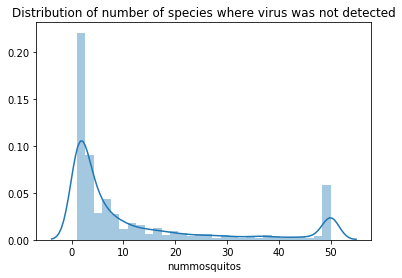

In [106]:
# looking for distribution of number of species where virus was not detected
sns.distplot(false_virus_df['nummosquitos'],bins=30)
plt.title('Distribution of number of species where virus was not detected');

In [107]:
# looking for distribution of number of species where virus was detected
sns.distplot(true_virus_df['nummosquitos'],bins=30)
plt.title('Distribution of number of species where virus was detected');

**Comment**

Two distribution plots showed that if the virus is not present - number of mosquities mostly between 0 and 10. But is the virus is present - number of mosquitoes closer to 50.

In [108]:
# Description of cells where the virus is and is not present
false_virus_df_descr = false_virus_df.describe().T.loc[:,['count','mean','std','min','max','50%']]
true_virus_df_descr = true_virus_df.describe().T.loc[:,['count','mean','std','min','max','50%']]
false_virus_df_descr.columns = [col + '_no' for col in false_virus_df_descr.columns]
true_virus_df_descr.columns = [col + '_vir' for col in true_virus_df_descr.columns]
description_df = pd.concat([false_virus_df_descr,true_virus_df_descr],axis=1)
description_df = description_df.reindex(sorted(description_df.columns), axis=1)

description_df

50%_no      50%_vir  count_no  count_vir       max_no  \
block              33.000000    36.000000    9955.0      551.0    98.000000   
latitude           41.846075    41.903002    9955.0      551.0    42.017430   
longitude         -87.694259   -87.725057    9955.0      551.0   -87.531635   
addressaccuracy     8.000000     8.000000    9955.0      551.0     9.000000   
nummosquitos        4.000000    24.000000    9955.0      551.0    50.000000   
wnvpresent          0.000000     1.000000    9955.0      551.0     0.000000   
day                15.000000    15.000000    9955.0      551.0    31.000000   
month               8.000000     8.000000    9955.0      551.0    10.000000   
year             2009.000000  2011.000000    9955.0      551.0  2013.000000   
iswnvspecies        1.000000     1.000000    9955.0      551.0     1.000000   
station             1.000000     1.000000    9955.0      551.0     1.000000   
tmax               28.330000    28.330000    9955.0      551.0    35.560000   
tmin               17.780000    18.890000    9955.0      551.0    24.440000   
tavg               23.330000    23.890000    9955.0      551.0    28.890000   
depart            -15.560000   -15.000000    9955.0      551.0    -7.780000   
dewpoint           15.560000    17.780000    9955.0      551.0    22.780000   
wetbulb            18.890000    20.560000    9955.0      551.0    24.440000   
heat                0.000000     0.000000    9955.0      551.0    15.000000   
cool                9.000000    10.000000    9955.0      551.0    19.000000   
sunrise           446.000000   505.000000    9955.0      551.0   557.000000   
sunset           1910.000000  1845.000000    9955.0      551.0  1931.000000   
depth               0.000000     0.000000    9955.0      551.0     0.000000   
snowfall            0.000000     0.000000    9955.0      551.0     0.050000   
preciptotal         0.000000     0.000000    9955.0      551.0     3.970000   
stnpressure        29.260000    29.260000    9955.0      551.0    29.590000   
sealevel           29.980000    29.980000    9955.0      551.0    30.330000   
resultspeed         5.500000     4.700000    9955.0      551.0    14.600000   
resultdir          19.000000    20.000000    9955.0      551.0    36.000000   
avgspeed            7.100000     6.600000    9955.0      551.0    15.000000   
humidity            7.220000     6.670000    9955.0      551.0    13.340000   

                     max_vir      mean_no     mean_vir       min_no  \
block              93.000000    35.659869    36.192377    10.000000   
latitude           42.011601    41.840378    41.854891    41.644612   
longitude         -87.531635   -87.698538   -87.724663   -87.930995   
addressaccuracy     9.000000     7.816775     7.869328     3.000000   
nummosquitos       50.000000    12.106479    26.350272     1.000000   
wnvpresent          1.000000     0.000000     1.000000     0.000000   
day                31.000000    15.324159    15.653358     1.000000   
month              10.000000     7.667403     8.147005     5.000000   
year             2013.000000  2009.548066  2010.085299  2007.000000   
iswnvspecies        1.000000     0.968358     1.000000     0.000000   
station             1.000000     1.000000     1.000000     1.000000   
tmax               35.560000    27.638641    28.682414    13.890000   
tmin               24.440000    16.992577    18.384229     5.000000   
tavg               28.890000    22.452146    23.690853    10.000000   
depart             -7.780000   -16.302239   -15.406842   -24.440000   
dewpoint           22.780000    15.330162    17.084574     3.890000   
wetbulb            24.440000    18.066997    19.469601     7.780000   
heat               13.000000     0.996484     0.266788     0.000000   
cool               19.000000     8.410045     9.909256     0.000000   
sunrise           552.000000   467.330588   488.813067   416.000000   
sunset           1931.000000  1871.871924  1852.473684  1720.000000   
depth     

In [109]:
# Creating a function for adding delay (14 day) weather
def add_tavg_14day(df):
    tdelta = dt.timedelta(days=14)
    df['date_delay'] = df['date'].map(lambda x:x+ tdelta)
    df = pd.merge(df,df_weather_st1[['date','tavg','wetbulb']],left_on='date_delay',right_on='date')
    df.drop(columns=['date_delay','tavg_x','wetbulb_x','date_y'],inplace=True)
    df.rename(columns={'wetbulb_y':'wetbulb','tavg_y':'tavg','date_x':'date'},inplace=True)
    return df

In [110]:
# Applying function for train and test dfs
main_df = add_tavg_14day(main_df)
main_df_test = add_tavg_14day(main_df_test)

In [111]:
# Changing trap name to number
# Function for removing letters and converting to int
def str_to_int(x):
    x = re.sub("[a-zA-Z]", "", x)
    return int(x)
main_df['trap'] = main_df['trap'].map(lambda x: str_to_int(x))
main_df_test['trap'] = main_df_test['trap'].map(lambda x: str_to_int(x))

In [112]:
wnv_df = main_df[main_df.wnvpresent == 1]
map_wnv = folium.Map(location=[wnv_df.latitude.mean(), wnv_df.longitude.mean()], zoom_start=12,
               tiles='Stamen Terrain')

for _, row in wnv_df.iterrows():
    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        dates=row.date,
        radius=5,
        popup=row.street,
        color='darkred',
        fill=True,
        fill_colour='darkred'
    ).add_to(map_wnv)
    
map_wnv

- Overview of the WnvPresent hotspots by traps/neigbhorhood across Chicago
- Did 2, maps 1 is in heatmap format below

In [113]:
def generateBaseMap(default_location=[wnv_df.latitude.mean(), wnv_df.longitude.mean()], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

# df_heatmap_wnv = df_heatmap[df_heatmap.wnvpresent==1].copy()
base_map = generateBaseMap()
HeatMap(data=wnv_df[['latitude', 'longitude', 'wnvpresent']].groupby
        (['latitude','longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=9).add_to(base_map)

base_map

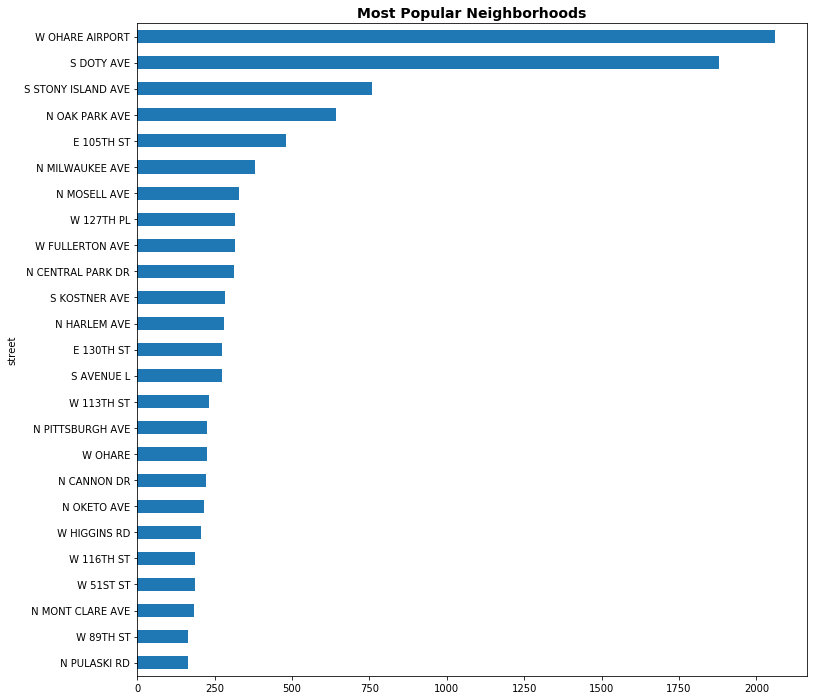

In [114]:
# Location, Location, Location
# Which is the neighborhood with the highest west nile virus present
wnv_df.groupby('street').nummosquitos.sum().sort_values().tail(25).plot(kind='barh', figsize= (12, 12))
plt.title('Most Popular Neighborhoods', size= 14, weight='bold')
plt.grid(False)
plt.show()

The top 5 neighborhoods with a high number of WnvPresent are W OHARE Airport, S Doty Avenue, S Stony Island Avenue, N Oak Park Avenue and E 105th Street.

The below heatmap shows the hotspots for each trap/neighbhorhood by year

In [115]:
heatmap_year = []
for y in wnv_df.year.sort_values().unique():

    heatmap_year.append(wnv_df.loc[y == wnv_df.year, ["latitude", "longitude"]]
                        .groupby(["latitude", "longitude"]).sum().reset_index().values.tolist())
    
base_map = generateBaseMap(default_zoom_start=8)
HeatMapWithTime(heatmap_year, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, 
                max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

## Feature Selection

## Modelling

### Dealing with imbalanced data

### Baseline Model

In [132]:
main_df['wnvpresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: wnvpresent, dtype: float64

**Comment**

From the baseline model, a sub group of a trap has a 94.7 percent chance of catching mosquitoes that carry the West Nile Virus

## Junyuan modelling

In [120]:
jy_df_main = main_df.copy()

In [122]:
jy_df_main = jy_df_main[['block','month', 'iswnvspecies','is_spray',
                         'tavg','tavg_14day', 'humidity','preciptotal',
                         'wnvpresent']]

In [123]:
jy_df_main.loc[:,'is_spray'] = jy_df_main.loc[:,'is_spray'].astype(int)

In [124]:
jy_df_main.dtypes

block             int64
month             int64
iswnvspecies      int32
is_spray          int32
tavg            float64
tavg_14day      float64
humidity        float64
preciptotal     float64
wnvpresent        int64
dtype: object

In [125]:
jy_df_main

block  month  iswnvspecies  is_spray   tavg  tavg_14day  humidity  \
0         41      5             1         0  23.33       20.56      8.89   
1         41      5             1         0  23.33       20.56      8.89   
2         62      5             1         0  23.33       20.56      8.89   
3         79      5             1         0  23.33       20.56      8.89   
4         79      5             1         0  23.33       20.56      8.89   
...      ...    ...           ...       ...    ...         ...       ...   
10501     51      9             1         0  17.22       22.22      6.11   
10502     58      9             1         1  17.22       22.22      6.11   
10503     17      9             1         0  17.22       22.22      6.11   
10504     71      9             1         1  17.22       22.22      6.11   
10505     42      9             1         0  17.22       22.22      6.11   

       preciptotal  wnvpresent  
0              0.0           0  
1              0.0           0  
2              0.0           0  
3              0.0           0  
4              0.0           0  
...            ...         ...  
10501          0.0           1  
10502          0.0           0  
10503          0.0           0  
10504          0.0           0  
10505          0.0           0  

[10506 rows x 9 columns]

In [126]:
jy_df_main_txnfrm = pd.get_dummies(jy_df_main,columns=['block','month'],drop_first=True)

In [127]:
jy_df_main_txnfrm.head()

iswnvspecies  is_spray   tavg  tavg_14day  humidity  preciptotal  \
0             1         0  23.33       20.56      8.89          0.0   
1             1         0  23.33       20.56      8.89          0.0   
2             1         0  23.33       20.56      8.89          0.0   
3             1         0  23.33       20.56      8.89          0.0   
4             1         0  23.33       20.56      8.89          0.0   

   wnvpresent  block_11  block_12  block_13  ...  block_90  block_91  \
0           0         0         0         0  ...         0         0   
1           0         0         0         0  ...         0         0   
2           0         0         0         0  ...         0         0   
3           0         0         0         0  ...         0         0   
4           0         0         0         0  ...         0         0   

   block_93  block_96  block_98  month_6  month_7  month_8  month_9  month_10  
0         0         0         0        0        0        0        0         0  
1         0         0         0        0        0        0        0         0  
2         0         0         0        0        0        0        0         0  
3         0         0         0        0        0        0        0         0  
4         0         0         0        0        0        0        0         0  

[5 rows x 75 columns]

In [128]:
X = jy_df_main_txnfrm.drop('wnvpresent',axis=1)
y = jy_df_main_txnfrm['wnvpresent']

**Comment**

Due to very low number of incidences of West Nile virus being present (value 1), there is a need to perform resampling.
Since there is a limited amount of data, we will be performing oversampling on the minority class.

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=42)

In [130]:
X = pd.concat([X_train, y_train], axis=1)

In [131]:
X_maj = X[X['wnvpresent']==0]
X_min = X[X['wnvpresent']==1]

In [132]:
X_min_os = resample(X_min,
                    replace=True,
                    n_samples=len(X_maj),
                    random_state=42)

In [133]:
X_os = pd.concat([X_maj, X_min_os])

In [134]:
X_os.wnvpresent.value_counts()

1    7466
0    7466
Name: wnvpresent, dtype: int64

In [135]:
X_train = X_os.drop('wnvpresent',axis=1)
y_train = X_os.wnvpresent

In [136]:
X_train.dtypes

iswnvspecies      int32
is_spray          int32
tavg            float64
tavg_14day      float64
humidity        float64
                 ...   
month_6           uint8
month_7           uint8
month_8           uint8
month_9           uint8
month_10          uint8
Length: 74, dtype: object

### Logistic regression

In [137]:
Cs = [0.01, 0.1, 1, 10, 100]

In [138]:
lr = LogisticRegressionCV(Cs=Cs,scoring='roc_auc',max_iter=2000)

In [139]:
lr.fit(X_train,y_train)

LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10, 100], class_weight=None, cv=None,
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=2000, multi_class='auto',
                     n_jobs=None, penalty='l2', random_state=None, refit=True,
                     scoring='roc_auc', solver='lbfgs', tol=0.0001, verbose=0)

In [140]:
lr.score(X_train,y_train)

0.7984625758389367

In [141]:
lr.score(X_test,y_test)

0.7705585736661602

In [142]:
pred = lr.predict(X_test)

In [143]:
confusion_matrix(y_test,pred)

array([[1551,  938],
       [  25,  113]], dtype=int64)

In [144]:
tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()

In [145]:
print('Accuracy: '.rjust(40) + f'{round((tp + tn) / (tp + fp + tn + fn),2)}')
print('Sensitivity: '.rjust(40) + f'{round((tp) / (tp + fn),2)}')
print('Specificity: '.rjust(40) + f'{round((tn) / (fp + tn),2)}')
print('Precision: '.rjust(40) + f'{round((tp) / (tp + fp),2)}')

                              Accuracy: 0.63
                           Sensitivity: 0.82
                           Specificity: 0.62
                             Precision: 0.11


### Random Forest

In [146]:
rf = RandomForestClassifier()

In [147]:
rf_param = {
    'n_estimators' : [100, 150, 200],
    'max_depth' : [None,1,2,3,4,5]
}

gs = GridSearchCV(rf, param_grid=rf_param,cv=5)

In [148]:
gs.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [149]:
gs.best_score_

0.8990082722832653

In [150]:
gs.score(X_train,y_train)

0.9168229306188053

In [151]:
gs.score(X_test,y_test)

0.7944423296535973

In [354]:
pred = gs.predict(X_test)

In [355]:
confusion_matrix(y_test,pred)

array([[2082,  411],
       [  70,   64]], dtype=int64)

In [356]:
tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()

In [357]:
print('Accuracy: '.rjust(40) + f'{round((tp + tn) / (tp + fp + tn + fn),2)}')
print('Sensitivity: '.rjust(40) + f'{round((tp) / (tp + fn),2)}')
print('Specificity: '.rjust(40) + f'{round((tn) / (fp + tn),2)}')
print('Precision: '.rjust(40) + f'{round((tp) / (tp + fp),2)}')

                              Accuracy: 0.82
                           Sensitivity: 0.48
                           Specificity: 0.84
                             Precision: 0.13


In [380]:
test_main_df2 = test_main_df[['block','month', 'iswnvspecies','is_spray',
                         'tavg','tavg_14day', 'humidity','preciptotal']]

In [381]:
test_main_df2 = pd.get_dummies(test_main_df2,columns=['block','month'],drop_first=True)

In [391]:
pred = gs.predict(test_main_df2)

In [392]:
# Create dataframe with submission format
df_sub = pd.DataFrame({'Id': test_main_df['id'].values, 'WnvPresent' : pred})

In [387]:
df_sub.head()

Id  WnvPresent
0   1           0
1   2           0
2   3           0
3   4           0
4   5           0

In [393]:
df_sub.to_csv('../datasets/Submission.csv',index=False)

## Bryan modeling

In [255]:
# Obtain top WNV hotspots for streets and traps

grouped_street = df_train_bydate_trap.groupby('street')['wnvpresent'].sum()
grouped_street.sort_values(inplace=True)

grouped_trap = df_train_bydate_trap.groupby('trap')['wnvpresent'].sum()
grouped_trap.sort_values(inplace=True)

In [256]:
# Copy DF

main_df_bryan = main_df.copy()

# Binary for is_spray

main_df_bryan['is_spray'] = [int(row == True) for row in main_df_bryan['is_spray']]

In [257]:
main_df_bryan.columns

Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent', 'day', 'month', 'year', 'iswnvspecies',
       'is_spray', 'station', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'sunrise', 'sunset', 'codesum', 'depth',
       'snowfall', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed',
       'resultdir', 'avgspeed', 'tavg_14day', 'humidity'],
      dtype='object')

In [258]:
# Select key features for our model fitting

feature_columns = ['month', 'year', 'block', 'is_spray', 'dewpoint','wnvpresent', 'sunrise','sunset', 'latitude', 'longitude', 'addressaccuracy', 'tavg','tmin', 'tmax']

In [259]:
# Select species that carry WNV

top_species = ['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS']

# Select the top 20 traps that have the highest ratio of WNV

top_traps = grouped_trap.sort_values(ascending=False)
top_traps = top_traps.index[:20].tolist()

# Select the top 5 streets that have the highest ratio of WNV

top_street = grouped_street.sort_values(ascending=False)
top_street = top_street.index[:5].tolist()

In [260]:
# Create dummy variables of top species, traps and streets

species_dummy = pd.get_dummies(main_df_bryan['species'], drop_first = True)
species_dummy = species_dummy.loc[:,top_species]

traps_dummy = pd.get_dummies(main_df_bryan['trap'], drop_first=True)
traps_dummy = traps_dummy.loc[:, top_traps]

street_dummy = pd.get_dummies(main_df_bryan['street'], drop_first=True)
street_dummy = street_dummy.loc[:, top_street]

traps_dummy.head()

T900  T003  T002  T115  T225  T011  T013  T223  T008  T138  T114  T082  \
0     0     0     1     0     0     0     0     0     0     0     0     0   
1     0     0     1     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   T030  T090  T061  T151  T128  T009  T903  T221  
0     0     0     0     0     0     0     0     0  
1     0     0     0     0     0     0     0     0  
2     0     0     0     0     0     0     0     0  
3     0     0     0     0     0     0     0     0  
4     0     0     0     0     0     0     0     0

In [261]:
# Select key features

main_df_bryan = main_df_bryan.loc[:, feature_columns]
main_df_bryan.head()

month  year  block  is_spray  dewpoint  wnvpresent  sunrise  sunset  \
0      5  2007     41         0     14.44           0    421.0  1917.0   
1      5  2007     41         0     14.44           0    421.0  1917.0   
2      5  2007     62         0     14.44           0    421.0  1917.0   
3      5  2007     79         0     14.44           0    421.0  1917.0   
4      5  2007     79         0     14.44           0    421.0  1917.0   

    latitude  longitude  addressaccuracy   tavg   tmin   tmax  
0  41.954690 -87.800991                9  23.33  15.56  31.11  
1  41.954690 -87.800991                9  23.33  15.56  31.11  
2  41.994991 -87.769279                9  23.33  15.56  31.11  
3  41.974089 -87.824812                8  23.33  15.56  31.11  
4  41.974089 -87.824812                8  23.33  15.56  31.11

In [262]:
main_df_bryan = pd.concat([main_df_bryan,traps_dummy],axis=1)
main_df_bryan = pd.concat([main_df_bryan,street_dummy],axis=1)
main_df_bryan = pd.concat([main_df_bryan,species_dummy],axis=1)
main_df_bryan.head()

month  year  block  is_spray  dewpoint  wnvpresent  sunrise  sunset  \
0      5  2007     41         0     14.44           0    421.0  1917.0   
1      5  2007     41         0     14.44           0    421.0  1917.0   
2      5  2007     62         0     14.44           0    421.0  1917.0   
3      5  2007     79         0     14.44           0    421.0  1917.0   
4      5  2007     79         0     14.44           0    421.0  1917.0   

    latitude  longitude  ...  T903  T221   W OHARE AIRPORT   N OAK PARK AVE  \
0  41.954690 -87.800991  ...     0     0                 0                1   
1  41.954690 -87.800991  ...     0     0                 0                1   
2  41.994991 -87.769279  ...     0     0                 0                0   
3  41.974089 -87.824812  ...     0     0                 0                0   
4  41.974089 -87.824812  ...     0     0                 0                0   

    N MILWAUKEE AVE   S DOTY AVE   S KOSTNER AVE  CULEX PIPIENS/RESTUANS  \
0                 0            0               0                       1   
1                 0            0               0                       0   
2                 0            0               0                       0   
3                 0            0               0                       1   
4                 0            0               0                       0   

   CULEX RESTUANS  CULEX PIPIENS  
0               0              0  
1               1              0  
2               1              0  
3               0              0  
4               1              0  

[5 rows x 42 columns]

In [263]:
main_df_bryan['wnvpresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: wnvpresent, dtype: float64

In [264]:
feature_columns.extend(top_traps)
feature_columns.extend(top_street)
feature_columns.extend(top_species)
feature_columns

['month',
 'year',
 'block',
 'is_spray',
 'dewpoint',
 'wnvpresent',
 'sunrise',
 'sunset',
 'latitude',
 'longitude',
 'addressaccuracy',
 'tavg',
 'tmin',
 'tmax',
 'T900',
 'T003',
 'T002',
 'T115',
 'T225',
 'T011',
 'T013',
 'T223',
 'T008',
 'T138',
 'T114',
 'T082',
 'T030',
 'T090',
 'T061',
 'T151',
 'T128',
 'T009',
 'T903',
 'T221',
 ' W OHARE AIRPORT',
 ' N OAK PARK AVE',
 ' N MILWAUKEE AVE',
 ' S DOTY AVE',
 ' S KOSTNER AVE',
 'CULEX PIPIENS/RESTUANS',
 'CULEX RESTUANS',
 'CULEX PIPIENS']

In [265]:
X = main_df_bryan[feature_columns]
y = main_df_bryan['wnvpresent']

X.drop(columns='wnvpresent', inplace=True)

X.shape

(10506, 41)

In [266]:
y.shape

(10506,)

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=0.25, stratify=y)

In [268]:
y_train.value_counts()

0    7466
1     413
Name: wnvpresent, dtype: int64

In [269]:
X = pd.concat([X_train, y_train], axis=1)
X.head()

month  year  block  is_spray  dewpoint  sunrise  sunset   latitude  \
10140      9  2013     82         0     14.44    522.0  1819.0  41.743402   
7737       9  2011     10         0     15.00    528.0  1809.0  41.899230   
8079       9  2011     71         0      5.00    547.0  1735.0  41.766202   
2449       8  2007     10         0     21.67    506.0  1843.0  41.726465   
449        7  2007     11         0     20.00    432.0  1924.0  41.862292   

       longitude  addressaccuracy  ...  T221   W OHARE AIRPORT  \
10140 -87.731435                8  ...     0                 0   
7737  -87.716788                9  ...     0                 0   
8079  -87.562889                9  ...     0                 0   
2449  -87.585413                5  ...     0                 0   
449   -87.648860                8  ...     0                 0   

        N OAK PARK AVE   N MILWAUKEE AVE   S DOTY AVE   S KOSTNER AVE  \
10140                0                 0            0               1   
7737                 0                 0            0               0   
8079                 0                 0            0               0   
2449                 0                 0            0               0   
449                  0                 0            0               0   

       CULEX PIPIENS/RESTUANS  CULEX RESTUANS  CULEX PIPIENS  wnvpresent  
10140                       0               0              1           1  
7737                        0               0              1           0  
8079                        1               0              0           0  
2449                        0               0              1           0  
449                         0               0              1           0  

[5 rows x 42 columns]

In [270]:
# separate minority and majority classes
wnv_false = X[X.wnvpresent==0]
wnv_true = X[X.wnvpresent==1]

# upsample minority
wnv_upsampled = resample(wnv_true,
                          replace=True, # sample with replacement
                          n_samples=len(wnv_false), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([wnv_false, wnv_upsampled])

# check new wnvpresent counts
upsampled.wnvpresent.value_counts()

1    7466
0    7466
Name: wnvpresent, dtype: int64

In [271]:
# update our training data with the upsampled data

X_train = upsampled.drop('wnvpresent',axis=1)
y_train = upsampled.wnvpresent

In [272]:
# Baseline accuracy 50% due to upsampling

y_train.value_counts()

1    7466
0    7466
Name: wnvpresent, dtype: int64

In [273]:
X_train.shape

(14932, 41)

In [274]:
y_train.shape

(14932,)

#### Testing Various other models

In [275]:
# Fit various models

# Decision Trees
rfc = RandomForestClassifier(random_state=42).fit(X_train, y_train)
et = ExtraTreesClassifier(random_state=42).fit(X_train, y_train)

# Boosting
gboost = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)
adaboost = AdaBoostClassifier(random_state=42).fit(X_train, y_train)

# Logistic Regression
lr = LogisticRegression(solver='liblinear', random_state=42).fit(X_train, y_train)

# KNearestNeighbors
knn = KNeighborsClassifier().fit(X_train, y_train)

In [276]:
# Observe general train / test accuracy for all models
# Extra Trees perform the best with 86% accuracy for our validation data
# All models appear to be overfit

print ('rfc train : {}'.format(rfc.score(X_train, y_train)))
print ('rfc test : {}'.format(rfc.score(X_test, y_test)))
print ('')
print ('et train : {}'.format(et.score(X_train, y_train)))
print ('et test : {}'.format(et.score(X_test, y_test)))
print ('')
print ('adaboost train : {}'.format(adaboost.score(X_train, y_train)))
print ('adaboost test : {}'.format(adaboost.score(X_test, y_test)))
print ('')
print ('gboost train : {}'.format(gboost.score(X_train, y_train)))
print ('gboost test : {}'.format(gboost.score(X_test, y_test)))
print ('')
print ('lr train : {}'.format(lr.score(X_train, y_train)))
print ('lr test : {}'.format(lr.score(X_test, y_test)))
print ('')
print ('knn train : {}'.format(knn.score(X_train, y_train)))
print ('knn test : {}'.format(knn.score(X_test, y_test)))

rfc train : 0.9727431020626842
rfc test : 0.8976018271792919

et train : 0.9727431020626842
et test : 0.8976018271792919

adaboost train : 0.7827484596839004
adaboost test : 0.7438142367719832

gboost train : 0.828690061612644
gboost test : 0.7689379520365436

lr train : 0.7319180283953924
lr test : 0.6924248191853826

knn train : 0.9393249397267613
knn test : 0.8332698896079178


In [277]:
tn, fp, fn, tp = confusion_matrix(y_test, et.predict(X_test)).ravel()

print("Extra Trees Confusion Matrix")
print("")
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
print("")
print("Precision: %s" % round((tp/(tp+fp)),2))
print("Recall: %s" % round((tp/(tp+fn)),2))

Extra Trees Confusion Matrix

True Negatives: 2327
False Positives: 162
False Negatives: 107
True Positives: 31

Precision: 0.16
Recall: 0.22


In [278]:
tn, fp, fn, tp = confusion_matrix(y_test, knn.predict(X_test)).ravel()

print("K-Nearest Neighbors Confusion Matrix")
print("")
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
print("")
print("Precision: %s" % round((tp/(tp+fp)),2))
print("Recall: %s" % round((tp/(tp+fn)),2))

K-Nearest Neighbors Confusion Matrix

True Negatives: 2126
False Positives: 363
False Negatives: 75
True Positives: 63

Precision: 0.15
Recall: 0.46


In [279]:
tn, fp, fn, tp = confusion_matrix(y_test, gboost.predict(X_test)).ravel()

print("Gradient Boost Confusion Matrix")
print("")
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
print("")
print("Precision: %s" % round((tp/(tp+fp)),2))
print("Recall: %s" % round((tp/(tp+fn)),2))

Gradient Boost Confusion Matrix

True Negatives: 1920
False Positives: 569
False Negatives: 38
True Positives: 100

Precision: 0.15
Recall: 0.72


In [280]:
gboost = GradientBoostingClassifier(random_state=42, n_estimators=100).fit(X_train, y_train)
gb_pred = gboost.predict(X_test)

In [281]:
pd.DataFrame(confusion_matrix(y_test, gb_pred))

0    1
0  1920  569
1    38  100

#### ROC AUC

In [282]:
# Import roc_auc_score.
from sklearn.metrics import roc_auc_score

# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in gboost.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

# Calculate ROC AUC

roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.8288512935175643

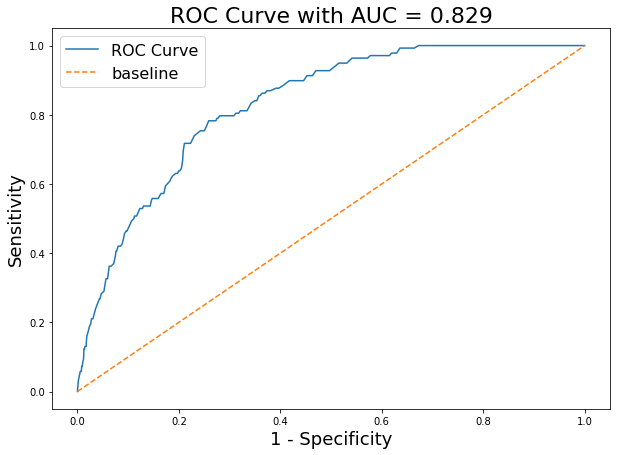

In [283]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [284]:
df_test.columns

Index(['id', 'date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'is_spray'],
      dtype='object')

In [285]:
df_test.shape

(116293, 12)

In [185]:
df_test_bryan = df_test

In [287]:
add_ispraycol(df_test_bryan)

In [288]:
# Codes
df_test_bryan.columns = df_test_bryan.columns.str.lower()
df_test_bryan['date'] = pd.to_datetime(df_test_bryan['date'])
# Create temproray dataframe by merging cleaned df_test_bryan and df_weather dataframes

df = pd.merge(df_test_bryan, df_weather_st1, on="date")
# Create dummy variables of top species, traps and streets

species_dummy = pd.get_dummies(df['species'], drop_first = True)
species_dummy = species_dummy.loc[:,top_species]

traps_dummy = pd.get_dummies(df['trap'], drop_first=True)
traps_dummy = traps_dummy.loc[:, top_traps]

street_dummy = pd.get_dummies(df['street'], drop_first=True)
street_dummy = street_dummy.loc[:, top_street]

df = pd.concat([df,traps_dummy],axis=1)
df = pd.concat([df,street_dummy],axis=1)
df = pd.concat([df,species_dummy],axis=1)

# Select key features
test_feature_columns = feature_columns
test_feature_columns.remove('wnvpresent')

df = df[test_feature_columns]

df.head()

month  year  block  is_spray  dewpoint  sunrise  sunset  latitude  \
0      6  2008     41     False     13.33    416.0  1926.0  41.95469   
1      6  2008     41     False     13.33    416.0  1926.0  41.95469   
2      6  2008     41     False     13.33    416.0  1926.0  41.95469   
3      6  2008     41     False     13.33    416.0  1926.0  41.95469   
4      6  2008     41     False     13.33    416.0  1926.0  41.95469   

   longitude  addressaccuracy  ...  T903  T221   W OHARE AIRPORT  \
0 -87.800991                9  ...     0     0                 0   
1 -87.800991                9  ...     0     0                 0   
2 -87.800991                9  ...     0     0                 0   
3 -87.800991                9  ...     0     0                 0   
4 -87.800991                9  ...     0     0                 0   

    N OAK PARK AVE   N MILWAUKEE AVE   S DOTY AVE   S KOSTNER AVE  \
0                1                 0            0               0   
1                1                 0            0               0   
2                1                 0            0               0   
3                1                 0            0               0   
4                1                 0            0               0   

   CULEX PIPIENS/RESTUANS  CULEX RESTUANS  CULEX PIPIENS  
0                       1               0              0  
1                       0               1              0  
2                       0               0              1  
3                       0               0              0  
4                       0               0              0  

[5 rows x 41 columns]

## Bryan Pushing his model here /END

## Anna modeling

In [298]:
X_all = main_df[['block', 'trap',
       'wnvpresent', 'month', 'year', 'iswnvspecies',
       'is_spray', 'dewpoint', 'heat',
       'cool','sunset',
       'preciptotal',
       'avgspeed', 'tavg', 'wetbulb']]
X = main_df[['block', 'trap',
       'month', 'year', 'iswnvspecies',
       'is_spray', 'dewpoint', 'heat',
       'cool','sunset',
       'preciptotal',
       'avgspeed', 'tavg', 'wetbulb']]
y = main_df['wnvpresent']
X_test_submit = main_df_test[['block', 'trap',
       'month', 'year', 'iswnvspecies',
       'is_spray', 'dewpoint', 'heat',
       'cool','sunset',
       'preciptotal',
       'avgspeed', 'tavg', 'wetbulb']]

#### Resampling with different methods

In [299]:
# defining minor and major classes
true_virus = X_all[X_all['wnvpresent']==1]
false_virus = X_all[X_all['wnvpresent']==0]

In [300]:
# doing undersampling of the majority class
on=True
if on:
    false_virus_downsampled = resample(false_virus,
                                    replace = False, # sample without replacement
                                    n_samples = len(true_virus), # match minority n
                                    random_state = 42) # reproducible results

    # combine minority and downsampled majority
    downsampled = pd.concat([false_virus_downsampled, true_virus])
    features = [col for col in downsampled if col !='wnvpresent']
    X_unders = downsampled[features]
    y_unders = downsampled['wnvpresent']
    # checking counts
    downsampled.wnvpresent.value_counts()

In [301]:
# Doing oversempling the minority class
# https://www.kaggle.com/tboyle10/methods-for-dealing-with-imbalanced-data
# Separate input features and target

on=True
if on:
    sm = SMOTE(sampling_strategy='minority',random_state=42)
    X_train_sm, y_train_sm = sm.fit_sample(X, y)
    oversempling_smote = pd.concat([X_train_sm, y_train_sm],axis=1)
    oversempling_smote.wnvpresent.value_counts()


In [302]:
# a combination of over-sampling and under-sampling
# https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
on=True
if on:
    smt = SMOTETomek(sampling_strategy='auto')
    X_smt, y_smt = smt.fit_sample(X, y)
    oversempling_smoteTomek = pd.concat([X_smt, y_smt],axis=1)
    oversempling_smoteTomek.wnvpresent.value_counts()

In [303]:
# Creating function for resamling
def resampling_dataset(how,X_train,y_train,on=True):
    """
    Resamples imbalanced dataset
    
    Takes:
    how (str) : 'under', 'over', 'smote'
    x - df - with features
    y - series - with target
    on - on/of function
    Returns:
    X,y
    """
    if on:
        if how == 'under':
            X = pd.concat([X_train, y_train])
            true_virus = X[X['wnvpresent']==1]
            false_virus = X[X['wnvpresent']==0]
            false_virus_downsampled = resample(false_virus,
                                    replace = False, # sample without replacement
                                    n_samples = len(true_virus), # match minority n
                                    random_state = 42) # reproducible results

            # combine minority and downsampled majority
            downsampled = pd.concat([false_virus_downsampled, true_virus])
            features = [col for col in downsampled if col !='wnvpresent']
            X_unders = downsampled[features]
            y_unders = downsampled['wnvpresent']
            return X_unders, y_unders
        elif how == 'over':
            sm = SMOTE(sampling_strategy='minority',random_state=42)
            X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
            oversempling_smote = pd.concat([X_train_sm, y_train_sm],axis=1)
            return X_train_sm, y_train_sm
        else:
            smt = SMOTETomek(sampling_strategy='auto')
            X_smt, y_smt = smt.fit_sample(X_train, y_train)
            return X_smt, y_smt

In [312]:
# Creating a function for boxplots
def subplot_boxplot(dataframe, list_columns,maintitle,blocks,figsize=(10,10)):
    """
    Plots a boxplot of the column which in the list. 
    
    Takes:
    dataframe
    list_columns - (list of str) - list of column's names.
    maintitle - (str) - main title for all scatterplots
    figsize - the custom size of a figure, 10x10 by default.
    blocks - (list of int) - list of block names
    
    Returns:
    Boxplot plot.
    """
#     for i_blk in range(2):
#         if i_blk < 2:
#             block_df = dataframe[(dataframe['block']==10)|(dataframe['block']==12)]
#             maintitle_upt = maintitle + f' , block 10,12'
#         else:
#             block_df = dataframe[(dataframe['block']!=10)|(dataframe['block']!=12)]
#             maintitle_upt = maintitle + ' , other blocks.'
    nrows = int(np.ceil(len(list_columns)/3))
    fig, ax = plt.subplots(nrows=nrows, ncols=3,figsize=figsize)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_columns):
        dataframe.boxplot(column=column, 
                    by='wnvpresent', ax=ax[i])
        ax[i].set_title(f'Boxplot of {column}\n', fontsize=20)
#         deleting empty subplot if list_of_list_columns is odd
    if len(list_columns)%2 ==0:
        fig.delaxes(ax[len(list_columns)]) 
    plt.tight_layout(pad=0.4, w_pad=2, h_pad=2)
    plt.suptitle(maintitle,fontsize=25)
    fig.subplots_adjust(top=0.95)
    plt.show()

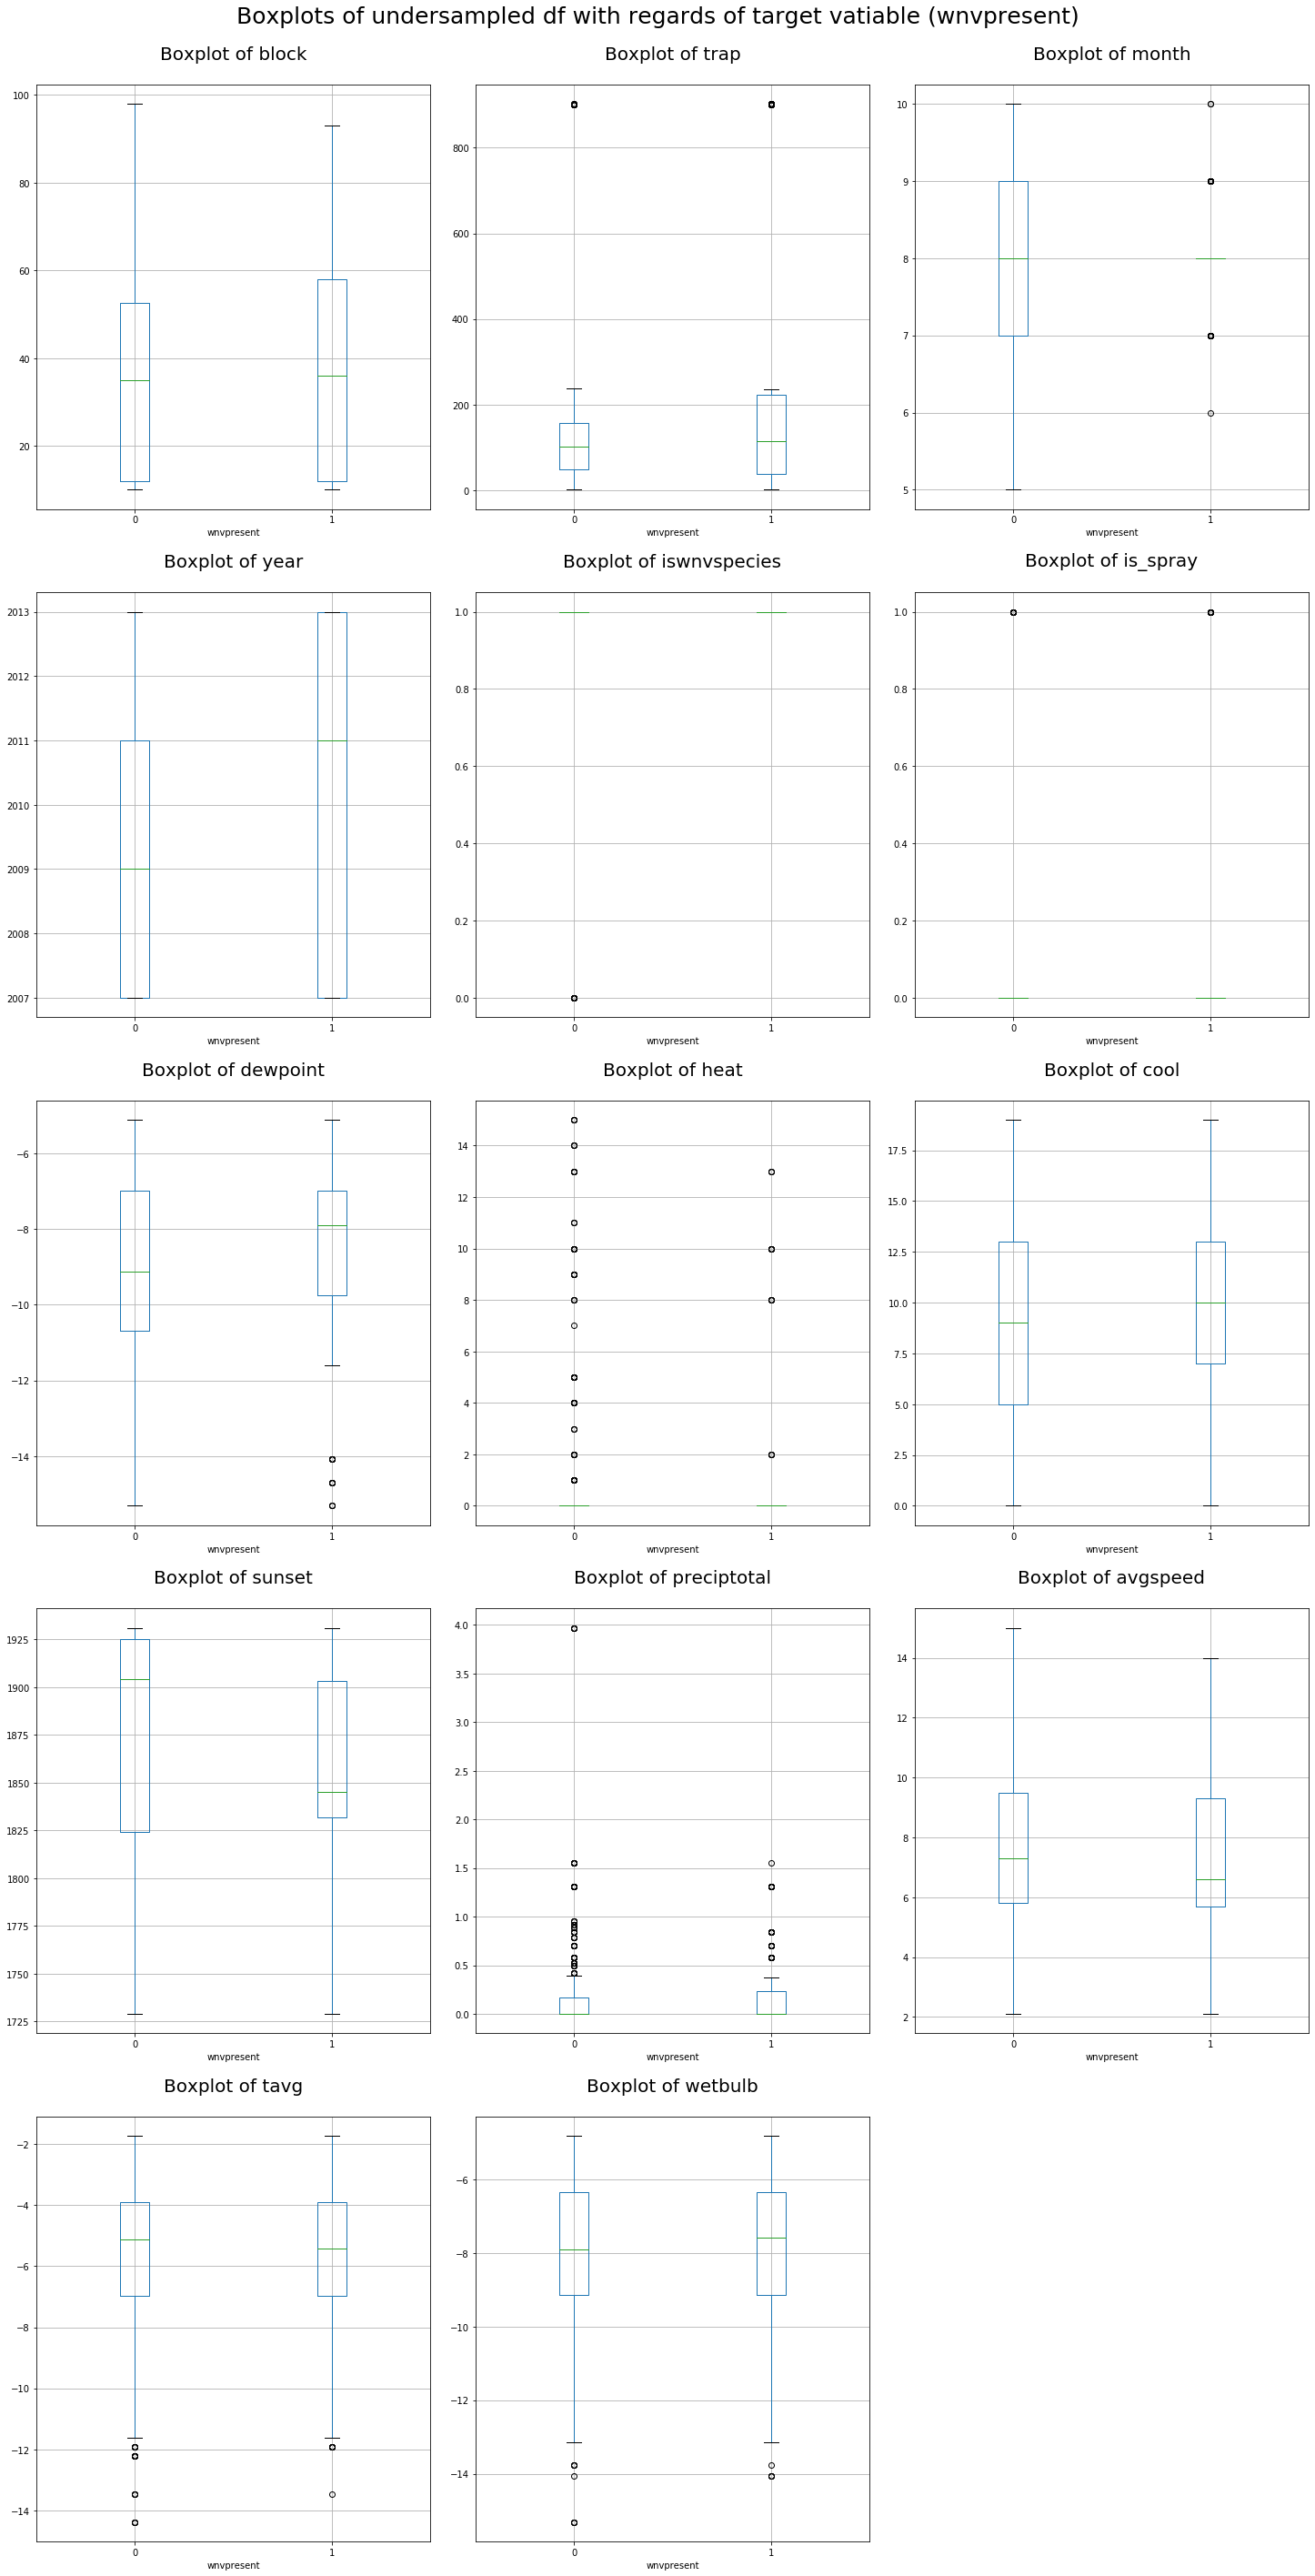

In [314]:
# boxplots of undersampeled data by virus column
# looking for different distribution of features by virus present
maintitle = 'Boxplots of undersampled df with regards of target vatiable (wnvpresent)'
subplot_boxplot(downsampled, X_unders.columns,maintitle,blocks=[10,12],figsize=(20,40))

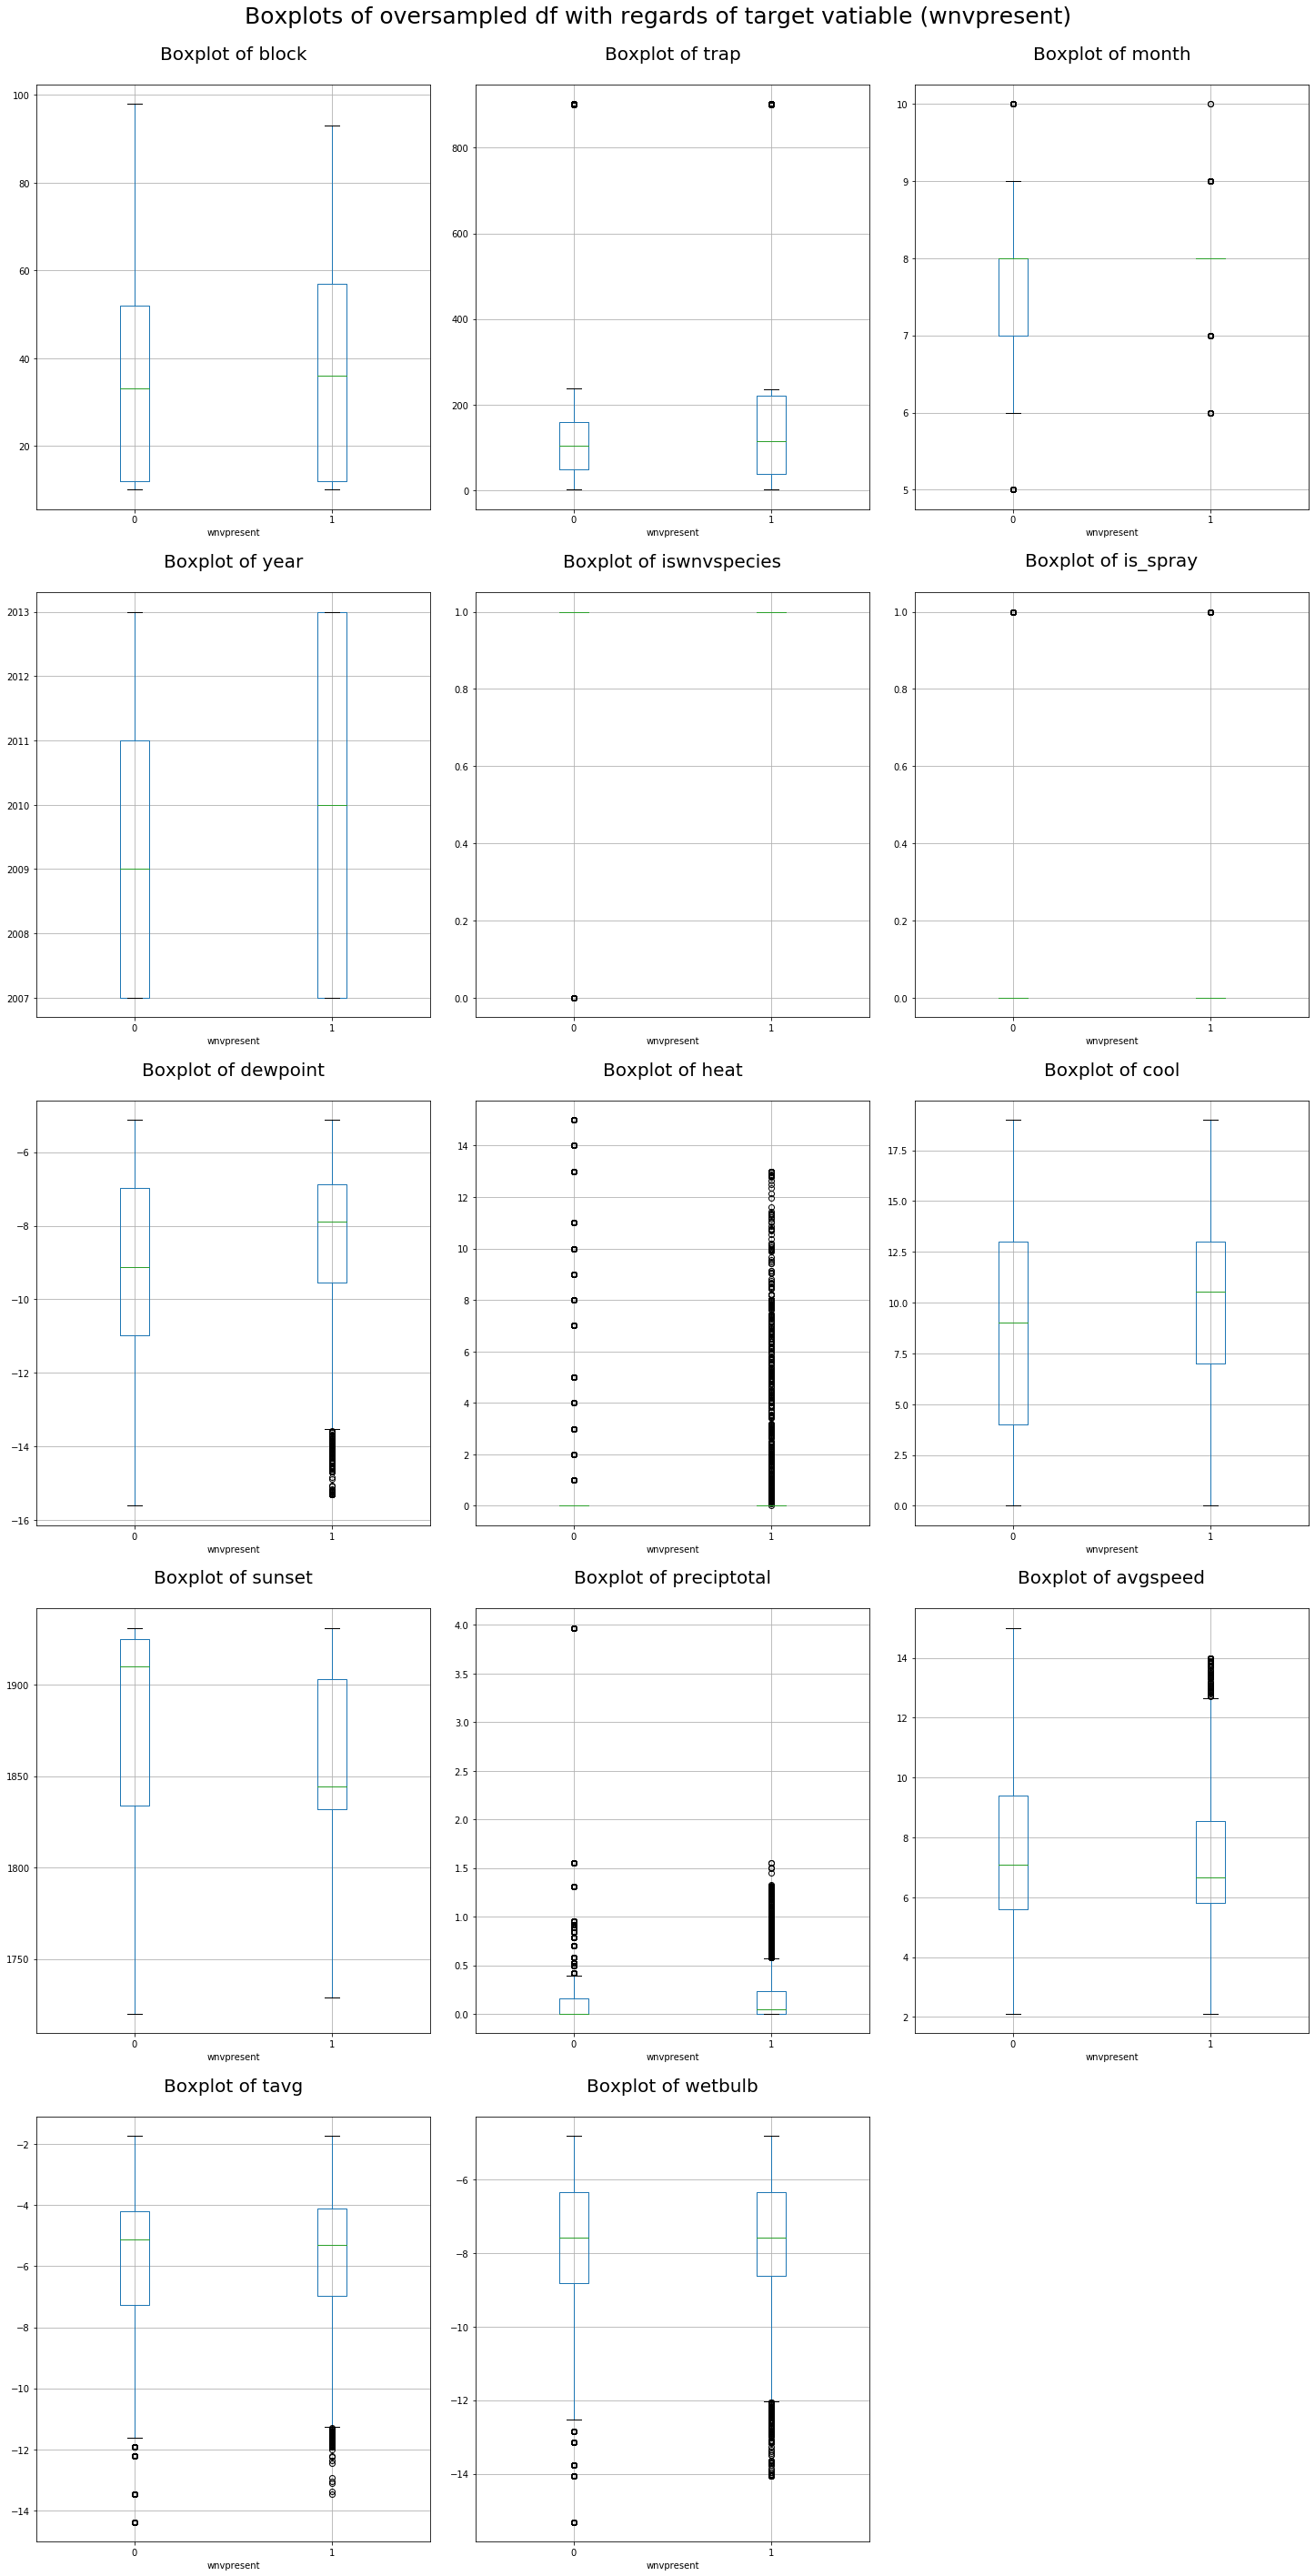

In [315]:
# boxplots of oversampeled data by virus column
# looking for different distribution of features by virus present
maintitle = 'Boxplots of oversampled df with regards of target vatiable (wnvpresent)'
subplot_boxplot(oversempling_smote, X_train_sm.columns,maintitle,blocks=[10,12],figsize=(20,40))

**Comment**

The difference between classes of the target variable (the presence of the virus) is not very distinct.

Next step is to check the performance of 5 models on the 3 new datasets with resampling.

In [305]:
# Change on to True to run a function
lr = LogisticRegression()
knn = KNeighborsClassifier()
svm = SVC()
dtree = DecisionTreeClassifier()
randtree = RandomForestClassifier()
sample_evaluation([X_unders, X_train_sm, X_smt],[y_unders, y_train_sm,y_smt],
                  models=[lr,knn,svm,dtree,randtree,],
                  names_samples=['undersampling','oversampling','smote'],
                 on=False)

undersampling
LogisticRegression
CV [0.6746988  0.73333333 0.67878788 0.7030303  0.74545455]
train 0.7106537530266344
test 0.7282608695652174
True Negatives: 90
False Positives: 48
False Negatives: 27
True Positives: 111
accuracy 0.728, precision 0.698,recall 0.804, f1 0.747
undersampling
KNeighborsClassifier
CV [0.69879518 0.6969697  0.70909091 0.75757576 0.69090909]
train 0.7953995157384988
test 0.7572463768115942
True Negatives: 104
False Positives: 34
False Negatives: 33
True Positives: 105
accuracy 0.757, precision 0.755,recall 0.761, f1 0.758
undersampling
SVC
CV [0.70481928 0.71515152 0.71515152 0.75757576 0.74545455]
train 0.7687651331719129
test 0.7536231884057971
True Negatives: 86
False Positives: 52
False Negatives: 16
True Positives: 122
accuracy 0.754, precision 0.701,recall 0.884, f1 0.782
undersampling
DecisionTreeClassifier
CV [0.6746988  0.72727273 0.72121212 0.75757576 0.72121212]
train 0.9564164648910412
test 0.6594202898550725
True Negatives: 88
False Positives: 50

                undersampling
                LogisticRegression
                CV [0.6746988  0.73333333 0.67878788 0.7030303  0.74545455]
                train 0.7106537530266344
                test 0.7282608695652174
                True Negatives: 90
                False Positives: 48
                False Negatives: 27
                True Positives: 111
                accuracy 0.728, precision 0.698,recall 0.804, f1 0.747
                ==================
                undersampling
                KNeighborsClassifier
                CV [0.69879518 0.6969697  0.70909091 0.75757576 0.69090909]
                train 0.7953995157384988
                test 0.7572463768115942
                True Negatives: 104
                False Positives: 34
                False Negatives: 33
                True Positives: 105
                accuracy 0.757, precision 0.755,recall 0.761, f1 0.758
                ==================
                undersampling
                SVC
                CV [0.70481928 0.71515152 0.71515152 0.75757576 0.74545455]
                train 0.7687651331719129
                test 0.7536231884057971
                True Negatives: 86
                False Positives: 52
                False Negatives: 16
                True Positives: 122
                accuracy 0.754, precision 0.701,recall 0.884, f1 0.782
                ==================
                undersampling
                DecisionTreeClassifier
                CV [0.6746988  0.72727273 0.72121212 0.75757576 0.72121212]
                train 0.9564164648910412
                test 0.6594202898550725
                True Negatives: 88
                False Positives: 50
                False Negatives: 44
                True Positives: 94
                accuracy 0.659, precision 0.653,recall 0.681, f1 0.667
                ==================
                undersampling
                RandomForestClassifier
                CV [0.72289157 0.74545455 0.76969697 0.77575758 0.72727273]
                train 0.9564164648910412
                test 0.7065217391304348
                True Negatives: 93
                False Positives: 45
                False Negatives: 36
                True Positives: 102
                accuracy 0.707, precision 0.694,recall 0.739, f1 0.716
                ==================
                oversampling
                LogisticRegression
                CV [0.69266823 0.70438567 0.68955124 0.70997991 0.70026792]
                train 0.7002410929547281
                test 0.7016874246685416
                True Negatives: 1617
                False Positives: 902
                False Negatives: 583
                True Positives: 1876
                accuracy 0.702, precision 0.675,recall 0.763, f1 0.716
                ==================
                oversampling
                KNeighborsClassifier
                CV [0.90257784 0.90659525 0.89986604 0.90087073 0.90622907]
                train 0.9313554781676936
                test 0.9031739654479711
                True Negatives: 2246
                False Positives: 273
                False Negatives: 209
                True Positives: 2250
                accuracy 0.903, precision 0.892,recall 0.915, f1 0.903
                ==================
                oversampling
                SVC
                CV [0.82457315 0.83963843 0.81212324 0.82518419 0.83188212]
                train 0.8341146530940262
                test 0.8256327842507031
                True Negatives: 1959
                False Positives: 560
                False Negatives: 308
                True Positives: 2151
                accuracy 0.826, precision 0.793,recall 0.875, f1 0.832
                ==================
                oversampling
                DecisionTreeClassifier
                CV [0.93036491 0.93304319 0.92498326 0.92866711 0.93067649]
                train 0.9607554245914813
                test 0.9381277621534753
                True Negatives: 2356
                False Positives: 163
                False Negatives: 145
                True Positives: 2314
                accuracy 0.938, precision 0.934,recall 0.941, f1 0.938
                ==================
                oversampling
                RandomForestClassifier
                CV [0.93973887 0.9390693  0.93134628 0.93469524 0.93670462]
                train 0.9607554245914813
                test 0.9433507432703897
                True Negatives: 2357
                False Positives: 162
                False Negatives: 120
                True Positives: 2339
                accuracy 0.943, precision 0.935,recall 0.951, f1 0.943
                ==================
                smote
                LogisticRegression
                CV [0.70241287 0.71102917 0.69761985 0.69795508 0.69862554]
                train 0.7056851702869402
                test 0.6985116653258246
                True Negatives: 1605
                False Positives: 940
                False Negatives: 559
                True Positives: 1868
                accuracy 0.699, precision 0.665,recall 0.77, f1 0.714
                ==================
                smote
                KNeighborsClassifier
                CV [0.90650134 0.90211197 0.89909487 0.89607777 0.89875964]
                train 0.9329578975596675
                test 0.9024537409493162
                True Negatives: 2251
                False Positives: 294
                False Negatives: 191
                True Positives: 2236
                accuracy 0.902, precision 0.884,recall 0.921, f1 0.902
                ==================
                smote
                SVC
                CV [0.82808311 0.8364063  0.82500838 0.83674154 0.82165605]
                train 0.8366183963529096
                test 0.8211987127916331
                True Negatives: 1952
                False Positives: 593
                False Negatives: 296
                True Positives: 2131
                accuracy 0.821, precision 0.782,recall 0.878, f1 0.827
                ==================
                smote
                DecisionTreeClassifier
                CV [0.9286193  0.92993631 0.93362387 0.92524304 0.91786792]
                train 0.9609814963797265
                test 0.9316170555108608
                True Negatives: 2361
                False Positives: 184
                False Negatives: 156
                True Positives: 2271
                accuracy 0.932, precision 0.925,recall 0.936, f1 0.93
                ==================
                smote
                RandomForestClassifier
                CV [0.93331099 0.94032853 0.9359705  0.93429433 0.93027154]
                train 0.9609814963797265
                test 0.9366452131938857
                True Negatives: 2331
                False Positives: 214
                False Negatives: 101
                True Positives: 2326
                accuracy 0.937, precision 0.916,recall 0.958, f1 0.937
                ==================

The models above illustrated that oversampling showing better results than undersampling or combination of over and undersampling. Preliminary, KNeighborsClassifier, DecisionTreeClassifier and RandomForestClassifier got better scores than LogisticRegression and SVC.

Next step is tune hyperparameters of models with gridsearch.

In [316]:
# Creating function for simple models evaluation
def sample_evaluation(X,y,models,names_samples,on=True):
    if on:
        for i in range(len(X)):
            X_train, X_test, y_train, y_test = train_test_split(X[i],y[i])
            ss = StandardScaler()
            X_train_scaled = ss.fit_transform(X_train)
            X_test_scaled = ss.transform(X_test)
            for model in models:
                cv_scores = cross_val_score(model,X_train_scaled,y_train)
                model.fit(X_train_scaled,y_train)
                train_score = model.score(X_train_scaled,y_train)
                test_score = model.score(X_test_scaled,y_test)
                print(names_samples[i])
                print(str(model).split('(')[0])
                print('CV',cv_scores)
                print('train',train_score)
                print('test',test_score)
                # set of predicted labels match the corresponding set of true labels
                y_predicted = model.predict(X_test_scaled)
                accuracy = accuracy_score(y_test, y_predicted)
                # ratio tp / (tp + fp)
                precision = precision_score(y_test, y_predicted)             
                # ratio tp / (tp + fn)
                recall = recall_score(y_test, y_predicted)
                # weighted average of the precision and recall
                # F1 = 2 * (precision * recall) / (precision + recall)
                f1 = f1_score(y_test, y_predicted)
                tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
                print("True Negatives: %s" % tn)
                print("False Positives: %s" % fp)
                print("False Negatives: %s" % fn)
                print("True Positives: %s" % tp)
                print(f'accuracy {round(accuracy,3)}, precision {round(precision,3)},recall {round(recall,3)}, f1 {round(f1,3)}')
                print('==================')

In [317]:
# Creating function for models evaluation with gridsearch parameters
def sample_evaluation_grid(X,y,models,params,names_samples,on=True):
    """
    Use different resample and different ML models to evaluate perfomance with gridsearch
    Takes:
    X - list of resampled X
    y - list of resampled y
    params - list of hyperparameters for gridsearch
    name_samples - list of str - name of resampling technique
    
    Prints accoracy score on train and test data
    """
    if on:
        for i in range(len(X)):
            X_train, X_test, y_train, y_test = train_test_split(X[i],y[i])
            ss = StandardScaler()
            X_train_scaled = ss.fit_transform(X_train)
            X_test_scaled = ss.transform(X_test)
            for j, model in enumerate(models):
                grid = GridSearchCV(model,param_grid=params[j])
                cv_scores = cross_val_score(grid,X_train_scaled,y_train)
                grid.fit(X_train,y_train)
                best_model = grid.best_estimator_
                best_model.fit(X_train_scaled,y_train)
                train_score = best_model.score(X_train_scaled,y_train)
                test_score = best_model.score(X_test_scaled,y_test)
                print(names_samples[i])
                print(str(model).split('(')[0])
                print(grid.best_params_)
                print('CV',cv_scores)
                print('train',train_score)
                print('test',test_score)
                print('==================')
                # set of predicted labels match the corresponding set of true labels
                y_predicted = best_model.predict(X_test_scaled)
                accuracy = accuracy_score(y_test, y_predicted)
                # ratio tp / (tp + fp)
                precision = precision_score(y_test, y_predicted)             
                # ratio tp / (tp + fn)
                recall = recall_score(y_test, y_predicted)
                # weighted average of the precision and recall
                # F1 = 2 * (precision * recall) / (precision + recall)
                f1 = f1_score(y_test, y_predicted)
                tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
                print("True Negatives: %s" % tn)
                print("False Positives: %s" % fp)
                print("False Negatives: %s" % fn)
                print("True Positives: %s" % tp)
                print(f'accuracy {round(accuracy,3)}, precision {round(precision,3)},recall {round(recall,3)}, f1 {round(f1,3)}')
                print('==================')

In [318]:
# Based on the above the oversampling method was chosen
# Creating an oversample df using a function written above
X,y = resampling_dataset('over',X,y,on=True)

In [320]:
# Change on to True to run a function
# Using function for models evaluation with gridsearch

lr = LogisticRegression(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
svm = SVC()
dtree = DecisionTreeClassifier()
randtree = RandomForestClassifier(n_jobs=-1)


sample_evaluation_grid([X],[y],
models=[lr,knn,svm,dtree,randtree,],names_samples=['oversampling'],
params = [{'penalty':['l2','none'],'tol':[0.0001,0.001],'max_iter':[500,700]},
         {'n_neighbors':[3,5,7], 'weights':['uniform','distance']},
         {'degree':[1,3,6], 'C':[0.1,0.3,1]},
        {'max_depth':[None,2,4],'min_samples_leaf':[1,2,3]},
        {'n_estimators':[80,100,120],'max_depth':[None,2,4],'min_samples_leaf':[1,2,3]}],
                       on=False)



#         'tree__max_depth':[None,2,4],
#         'tree__min_samples_leaf':[1,2,3],
#         'randomtree__max_depth':[None,2,4],
#         'tree__min_samples_leaf':[1,2,3],
#         'gradboost__max_depth':[4,5], 
#         'gradboost__n_estimators':[100,125],
#         'gradboost__learning_rate':[0.1,0.3,0.5],


oversampling
LogisticRegression
{'max_iter': 700, 'penalty': 'none', 'tol': 0.0001}
CV [0.68429863 0.70840308 0.69993302 0.70361688 0.70060281]
train 0.6989016876506831
test 0.691844114102049
True Negatives: 1541
False Positives: 936
False Negatives: 598
True Positives: 1903
accuracy 0.692, precision 0.67,recall 0.761, f1 0.713
oversampling
KNeighborsClassifier
{'n_neighbors': 3, 'weights': 'distance'}
CV [0.92065618 0.90659525 0.91929002 0.91393168 0.91292699]
train 0.9596169300830432
test 0.928887103254319
True Negatives: 2287
False Positives: 190
False Negatives: 164
True Positives: 2337
accuracy 0.929, precision 0.925,recall 0.934, f1 0.93
oversampling
SVC
{'C': 1, 'degree': 1}
CV [0.81888182 0.83662538 0.8248493  0.82920295 0.8241795 ]
train 0.8327752477899812
test 0.8312575331458417
True Negatives: 1938
False Positives: 539
False Negatives: 301
True Positives: 2200
accuracy 0.831, precision 0.803,recall 0.88, f1 0.84
oversampling
DecisionTreeClassifier
{'max_depth': None, 'min_sa

            oversampling
            LogisticRegression
            {'max_iter': 700, 'penalty': 'none', 'tol': 0.0001}
            CV [0.68429863 0.70840308 0.69993302 0.70361688 0.70060281]
            train 0.6989016876506831
            test 0.691844114102049
            ==================
            True Negatives: 1541
            False Positives: 936
            False Negatives: 598
            True Positives: 1903
            accuracy 0.692, precision 0.67,recall 0.761, f1 0.713
            ==================
            oversampling
            KNeighborsClassifier
            {'n_neighbors': 3, 'weights': 'distance'}
            CV [0.92065618 0.90659525 0.91929002 0.91393168 0.91292699]
            train 0.9596169300830432
            test 0.928887103254319
            ==================
            True Negatives: 2287
            False Positives: 190
            False Negatives: 164
            True Positives: 2337
            accuracy 0.929, precision 0.925,recall 0.934, f1 0.93
            ==================
            oversampling
            SVC
            {'C': 1, 'degree': 1}
            CV [0.81888182 0.83662538 0.8248493  0.82920295 0.8241795 ]
            train 0.8327752477899812
            test 0.8312575331458417
            ==================
            True Negatives: 1938
            False Positives: 539
            False Negatives: 301
            True Positives: 2200
            accuracy 0.831, precision 0.803,recall 0.88, f1 0.84
            ==================
            oversampling
            DecisionTreeClassifier
            {'max_depth': None, 'min_samples_leaf': 1}
            CV [0.93873452 0.92567794 0.93034159 0.92933691 0.92531815]
            train 0.9618939190999196
            test 0.9367215749296907
            ==================
            True Negatives: 2305
            False Positives: 172
            False Negatives: 143
            True Positives: 2358
            accuracy 0.937, precision 0.932,recall 0.943, f1 0.937
            ==================
            oversampling
            RandomForestClassifier
            {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 120}
            CV [0.9474389  0.9306997  0.93636973 0.93503014 0.93168118]
            train 0.9618939190999196
            test 0.9427480916030534
            ==================
            True Negatives: 2305
            False Positives: 172
            False Negatives: 113
            True Positives: 2388
            accuracy 0.943, precision 0.933,recall 0.955, f1 0.944
            ==================

In [322]:
# Evaluation of ensambles of models

bag = BaggingClassifier()
gradb = GradientBoostingClassifier()
ada = AdaBoostClassifier()


sample_evaluation([X],[y],
models=[gradb],names_samples=['oversampling'],on=False)
sample_evaluation_grid([X],[y],
models=[bag,ada],names_samples=['oversampling'],
params = [
         {'base_estimator':[
                             KNeighborsClassifier(n_jobs=-1,n_neighbors= 3,weights='distance'),
                             RandomForestClassifier(max_depth=None,min_samples_leaf=2)]},
         ]
                      ,on=False)

oversampling
GradientBoostingClassifier
CV [0.85771677 0.86240375 0.8596785  0.84695244 0.86537173]
train 0.8636485400482186
test 0.8638007231820009
True Negatives: 2067
False Positives: 435
False Negatives: 243
True Positives: 2233
accuracy 0.864, precision 0.837,recall 0.902, f1 0.868


C:\Users\anpej\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: KNeighborsClassifier doesn't support sample_weight.

  FitFailedWarning)
C:\Users\anpej\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: KNeighborsClassifier doesn't support sample_weight.

  FitFailedWarning)
C:\Users\anpej\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: KNeighborsClassifier doesn't support sample_weight.

  FitFailedWarning)
C:\Users\anpej\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFail

oversampling
AdaBoostClassifier
{'base_estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)}
CV [0.93505189 0.93371276 0.93770931 0.93402545 0.93737441]
train 0.9610233056522904
test 0.937324226597027
True Negatives: 2296
False Positives: 185
False Negatives: 127
True Positives: 2370
accuracy 0.937, precision 0.928,recall 0.949, f1 0.938


            oversampling
            BaggingClassifier
            {'base_estimator': RandomForestClassifier
            (bootstrap=True, ccp_alpha=0.0, class_weight=None,
                                   criterion='gini', max_depth=None, max_features='auto',
                                   max_leaf_nodes=None, max_samples=None,
                                   min_impurity_decrease=0.0, min_impurity_split=None,
                                   min_samples_leaf=2, min_samples_split=2,
                                   min_weight_fraction_leaf=0.0, n_estimators=100,
                                   n_jobs=None, oob_score=False, random_state=None,
                                   verbose=0, warm_start=False)}
            CV [0.92400402 0.93404754 0.93235097 0.9300067  0.93034159]
            train 0.9513795874631663
            test 0.9278826838087585
            ==================
            True Negatives: 2287
            False Positives: 207
            False Negatives: 152
            True Positives: 2332
            accuracy 0.928, precision 0.918,recall 0.939, f1 0.929
            ==================
            
            oversampling
            GradientBoostingClassifier
            CV [0.85771677 0.86240375 0.8596785  0.84695244 0.86537173]
            train 0.8636485400482186
            test 0.8638007231820009
            True Negatives: 2067
            False Positives: 435
            False Negatives: 243
            True Positives: 2233
            accuracy 0.864, precision 0.837,recall 0.902, f1 0.868
            oversampling
            
            AdaBoostClassifier
            {'base_estimator': RandomForestClassifier(bootstrap=True, 
            ccp_alpha=0.0, class_weight=None,
                                   criterion='gini', max_depth=None, max_features='auto',
                                   max_leaf_nodes=None, max_samples=None,
                                   min_impurity_decrease=0.0, min_impurity_split=None,
                                   min_samples_leaf=2, min_samples_split=2,
                                   min_weight_fraction_leaf=0.0, n_estimators=100,
                                   n_jobs=None, oob_score=False, random_state=None,
                                   verbose=0, warm_start=False)}
            CV [0.93505189 0.93371276 0.93770931 0.93402545 0.93737441]
            train 0.9610233056522904
            test 0.937324226597027
            ==================
            True Negatives: 2296
            False Positives: 185
            False Negatives: 127
            True Positives: 2370
            accuracy 0.937, precision 0.928,recall 0.949, f1 0.938

#### Based on the models' perfomance above, Voting classifier will be build 

In [325]:
# Creation a voting classifier with best models
vc = VotingClassifier(estimators=[('knn',KNeighborsClassifier(weights='distance')),
        ('ada',AdaBoostClassifier(base_estimator=RandomForestClassifier(min_samples_leaf=2))),
    ('bagg',BaggingClassifier(base_estimator=RandomForestClassifier(min_samples_leaf=2)))
                                  ],voting='soft')
# Using gridsearch for better evaluation
on=True
if on:
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)
    
#     gs_vc = GridSearchCV(vc,param_grid=vc_params)
    vc.fit(X_train_scaled,y_train)
    print(vc.score(X_train_scaled,y_train))
    print(vc.score(X_test_scaled,y_test))
    # Evaluation
    # set of predicted labels match the corresponding set of true labels
    y_predicted = vc.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_predicted)
    # ratio tp / (tp + fp)
    precision = precision_score(y_test, y_predicted)             
    # ratio tp / (tp + fn)
    recall = recall_score(y_test, y_predicted)
    # weighted average of the precision and recall
    # F1 = 2 * (precision * recall) / (precision + recall)
    f1 = f1_score(y_test, y_predicted)
    tn, fp, fn, tp = confusion_matrix(y_test, y_predicted).ravel()
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    print(f'accuracy {round(accuracy,3)}, precision {round(precision,3)},recall {round(recall,3)}, f1 {round(f1,3)}')
    print('==================')

0.9605545137958746
0.9365206910405786
True Negatives: 2313
False Positives: 178
False Negatives: 138
True Positives: 2349
accuracy 0.937, precision 0.93,recall 0.945, f1 0.937


    VotingClassifier
    train accuracy 0.9605545137958746
    test accuracy 0.9365206910405786
    True Negatives: 2313
    False Positives: 178
    False Negatives: 138
    True Positives: 2349
    accuracy 0.937, precision 0.93,recall 0.945, f1 0.937


In [335]:
# Creating Receiver Operating Characteristic (ROC) Curve
def roc_curve(model,X_test):
    pred_proba = [i[1] for i in model.predict_proba(X_test)]
    pred_df = pd.DataFrame({'true_values': y_test,
                            'pred_probs':pred_proba})
    plt.figure(figsize = (10,7))

    # Create threshold values. (Dashed red line in image.)
    thresholds = np.linspace(0, 1, 200)

    # Define function to calculate sensitivity. (True positive rate.)
    def TPR(df, true_col, pred_prob_col, threshold):
        true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
        false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
        return true_positive / (true_positive + false_negative)


    # Define function to calculate 1 - specificity. (False positive rate.)
    def FPR(df, true_col, pred_prob_col, threshold):
        true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
        false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
        return 1 - (true_negative / (true_negative + false_positive))

    # Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
    tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
    fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

    # Plot ROC curve.
    plt.plot(fpr_values, # False Positive Rate on X-axis
             tpr_values, # True Positive Rate on Y-axis
             label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')

    # Label axes.
    plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
    plt.ylabel('Recall', fontsize=18)
    plt.xlabel('1 - Specificity', fontsize=18)

    # Create legend.
    plt.legend(fontsize=16);

In [341]:
# Creating distribution of divided probability
def div_prob(model,X_test):
    pred_proba = [i[1] for i in model.predict_proba(X_test)]
    pred_df = pd.DataFrame({'true_values': y_test,
                            'pred_probs':pred_proba})
    plt.figure(figsize = (10,7))
    # Create two histograms of observations.
    plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
             bins=25,
             color='#65a8a7',
             alpha = 0.5,
             label='WNVirus not present')
    plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
             bins=25,
             color='#fcba03',
             alpha = 0.5,
             label='WNVirus present')

    # Add vertical line at P(Outcome = 1) = 0.5.
    plt.vlines(x=0.5,
               ymin = 0,
               ymax = 65,
               color='r',
               linestyle = '--')

    # Label axes.
    plt.title('Distribution of Probability', fontsize=22)
    plt.ylabel('Frequency', fontsize=18)
    plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)
    plt.text(y = 40,x = 0.1,s = 'True negative',color='blue')
    plt.text(y = 10,x = 0.25,s = 'False negative',color='orange')
    plt.text(y = 10,x = 0.55,s = 'False positive',color='blue')
    plt.text(y = 40,x = 0.75,s = 'True positive',color='orange')
    # Create legend.
    plt.legend(fontsize=20,loc='upper center');

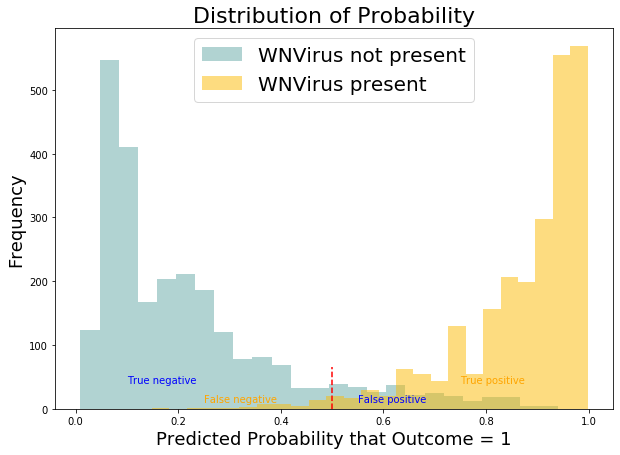

In [332]:
# Evaluation VotingClassifier
div_prob(vc,X_test_scaled)

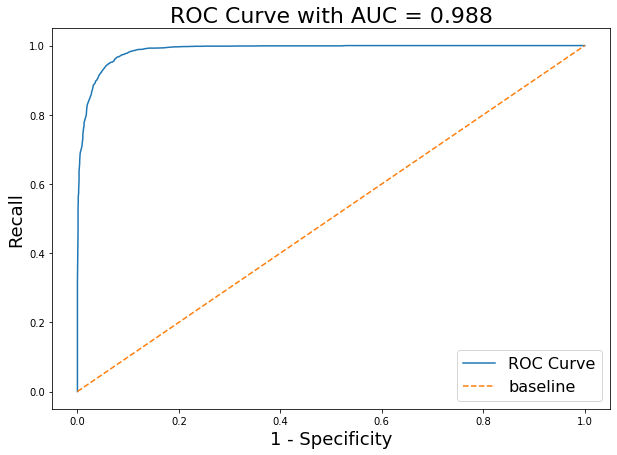

In [337]:
roc_curve(vc,X_test_scaled)

In [338]:
X_test_subm_scaled = ss.transform(X_test_submit)
submit_df = pd.DataFrame()
submit_df['id'] = main_df_test['id']
submit_df['wnvpresent'] = vc.predict(X_test_subm_scaled)
submit_df.to_csv('../datasets/submission.csv', index=False)

### Kaggle submition scores

|Private Score|Public Score|
|--|--|
|0.61716|0.63410|

From the scores, we can conclude that our model generalizability is not so well.


In [359]:
looking for false negative predictions
pred_proba = vc.predict_proba(X_test_scaled)
pred = vc.predict(X_test_scaled)
pred_df = pd.DataFrame({'true_values': y_test,
                        'predict':pred,
                        'pred_probs':list(pred_proba)})

wrong_predictions=pred_df[(pred_df['true_values']-pred_df['predict'])==1]
wrong_predictions
# X_test.loc[wrong_predictions.index,:]

true_values  predict                                 pred_probs
9015             1        0   [0.5118266410451519, 0.4881733589548481]
18279            1        0   [0.5118266410451519, 0.4881733589548481]
15959            1        0   [0.5051059965870229, 0.4948940034129771]
14895            1        0   [0.5051059965870229, 0.4948940034129771]
17117            1        0   [0.544917374464152, 0.45508262553584794]
7399             1        0  [0.5918419444791706, 0.40815805552082934]
8854             1        0   [0.5567206914202392, 0.4432793085797609]
8998             1        0   [0.5661400648589984, 0.4338599351410017]
17984            1        0   [0.5844075257136284, 0.4155924742863715]
10346            1        0  [0.5370517132507983, 0.46294828674920163]
10484            1        0   [0.7036578411650635, 0.2963421588349365]
3366             1        0  [0.6831646833896446, 0.31683531661035524]
9250             1        0    [0.568325623760095, 0.4316743762399051]
10059            1        0   [0.5235333874117357, 0.4764666125882642]
9437             1        0   [0.5474568443470466, 0.4525431556529535]
1730             1        0  [0.6350089818868243, 0.36499101811317575]
13993            1        0  [0.8217816746373251, 0.17821832536267498]
13639            1        0   [0.5051059965870229, 0.4948940034129771]
1671             1        0   [0.5051059965870229, 0.4948940034129771]
17758            1        0  [0.7061305208738217, 0.29386947912617833]
1709             1        0     [0.614567527882884, 0.385432472117116]
10896            1        0   [0.5292731663384768, 0.4707268336615232]
12529            1        0  [0.8217816746373251, 0.17821832536267498]
1599             1        0   [0.5100849444491496, 0.4899150555508502]
1411             1        0  [0.7068941995710661, 0.29310580042893375]
7624             1        0   [0.6577201509164025, 0.3422798490835975]
11305            1        0   [0.5844075257136284, 0.4155924742863715]
7588             1        0   [0.5859120554426586, 0.4140879445573413]
5624             1        0  [0.5557932414232799, 0.44420675857672015]
7981             1        0   [0.6844185199198721, 0.3155814800801279]
19061            1        0   [0.5267148172241715, 0.4732851827758286]
19395            1        0   [0.5192993897874784, 0.4807006102125216]
2153             1        0   [0.6084687679714371, 0.3915312320285628]
7919             1        0   [0.7713896765131897, 0.2286103234868103]
10612            1        0   [0.5051059965870229, 0.4948940034129771]
13890            1        0   [0.5561631884064817, 0.4438368115935183]
9468             1        0  [0.5932443263240258, 0.40675567367597426]
11044            1        0    [0.609204558118524, 0.3907954418814758]

Most of false negative probabilities are close to threshold of 0.5.
Let's use threshold of 0.6

## Generate Submission data

In [289]:
# Create an empty dataframe
submission = pd.DataFrame()

# Assign a column 'Id' with values identical to the test dataframe
submission['id'] = df_test_bryan.id

In [290]:
# Get our test dataframe with our feature columns
# This is equivalent to 'X' in our training data
feats = df[test_feature_columns]

In [291]:
feats.fillna(0, inplace=True)

In [294]:
# Perform predictions of WNV Present based on our selected features
# with our Gradient Boosting Model

predictions = gboost.predict(feats)

In [298]:
# Input our predictions into a new column for our submission
# matching the wnv classification to the respective Id
submission['wnvpresent'] = predictions
submission.head()

id  wnvpresent
0   1           0
1   2           0
2   3           0
3   4           0
4   5           0

In [299]:
# Save our dataframe into a csv file for submission
submission.to_csv('submission.csv', index=False)

# 0.64 Public Score 0.59 Private Score

---

In [338]:
X_test_subm_scaled = ss.transform(X_test_submit)
submit_df = pd.DataFrame()
submit_df['id'] = main_df_test['id']
submit_df['wnvpresent'] = vc.predict(X_test_subm_scaled)
submit_df.to_csv('../datasets/submission.csv', index=False)

### Kaggle submition scores

|Private Score|Public Score|
|--|--|
|0.61716|0.63410|

From the scores, we can conclude that our model generalizability is not so well.


---

In [1216]:
X = df_test_eval
X_scaled = ss.transform(X)

In [1217]:
# Predictions
pred = lasso.predict(X_scaled)

In [1218]:
# Create dataframe with submission format
df_sub = pd.DataFrame({'Id': df_test['id'].values, 'SalePrice' : pred})

In [1219]:
# Export to csv
df_sub.to_csv('../datasets/submission.csv', index=False)

- Weather Data Dictionary

|Feature|Type|Dataset|Description
|---|---|---|---|
|**station**|*int*|Weather|Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT (AWOS)
|**date**|*datetime*|Weather|Date Period of Weather Data (YYYY-MM-DD)
|**tmax**|*float*|Weather|Maximum Daily Temperature (Degrees Celsius)
|**tmin**|*float*|Weather|Minimum Daily Temperature (Degrees Celsius)
|**tavg**|*float*|Weather|Average Daily Temperature (Degrees Celsius)
|**depart**|*float*|Weather|Daily Departure From Normal (Degrees Celsius)
|**dewpoint**|*float*|Weather|Average Daily Dew Point (Degrees Celsius)
|**wetbulb**|*float*|Weather|Average Daily Wetbulb (Degrees Celsius)
|**heat**|*float*|Weather|Daily Heating (Season Begins In July)
|**cool**|*float*|Weather|Daily Cooling (Season Begins In January)
|**sunrise**|*float*|Weather|Daily Sunrise Time (HHMM)
|**sunset**|*float*|Weather|Daily Sunset Time (HHMM)
|**codesum**|*object*|Weather|Significant Weather Types/Phenomena
|**depth**|*float*|Weather|Measurement of Snow/Ice On Ground(Inches)
|**snowfall**|*float*|Weather|Measurement of Snowfall (Inches and Tenths)
|**preciptotal**|*float*|Weather|Daily Precipitation (Inches)
|**stnpressure**|*float*|Weather|Average Daily Station Pressure (Inches HG)
|**sealevel**|*float*|Weather|Average Daily Sea Level Pressure (Inches HG)
|**resultspeed**|*float*|Weather|Daily Resultant Wind Speed (MPH)
|**resultdir**|*int*|Weather|Daily Resultant Direction (Whole Degrees)
|**avgspeed**|*float*|Weather|Average Daily Resultant Wind Speed (MPH)
|**day**|*int*|Weather|Date Period of Weather Data (Day)
|**month**|*int*|Weather|Date Period of Weather Data (Month)
|**year**|*int*|Weather|Date Period of Weather Data (Year)